In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import datetime

from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from common_functions import *

def plot_forecast(test, forecast, date_col='ds', true_label='y', predicted_label='yhat'):
    plt.figure(figsize=(10,6))
    plt.plot(test[date_col], test[true_label], label='Actual')
    plt.plot(test[date_col], forecast[predicted_label], label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel(true_label)
    plt.title('Actual vs Predicted ' + true_label)
    plt.show()


def train_prophet(train_data):
    model = Prophet()
    model.fit(train_data)
    return model

def forecast_prophet(model, test_data):
    forecast = model.predict(test_data)
    return forecast


def split_data(df, offset, train_size, test_size):
    """
    Split the data into train and test sets.

    Parameters:
    df (DataFrame): The input dataframe containing the time series data.
    offset (int): The number of days to offset the start of the train data from the beginning of the dataframe.
    train_size (int): The number of months to include in the train data.
    test_size (int): The number of days to include in the test data.

    Returns:
    train_data (DataFrame): The train data.
    test_data (DataFrame): The test data.
    start_date (Timestamp): The start date of the train data.
    slice_date (Timestamp): The end date of the train data.
    end_date (Timestamp): The end date of the test data.
    """
    train_data = df[(df.ds >= df.ds.min() + pd.DateOffset(days=offset)) & (df.ds <= df.ds.min() + pd.DateOffset(days=offset) + pd.DateOffset(months=train_size))]

    # If there is no number_of_test_values left in the df to the end, then train and test should be none
    if train_data.ds.max() + pd.DateOffset(days=test_size) > df.ds.max():
        return None, None, None, None, None
    
    test_data = df[(df.ds > train_data.ds.max()) & (df.ds <= train_data.ds.max() + pd.DateOffset(days=test_size))]

    start_date, slice_date, end_date = train_data.ds.min(), train_data.ds.max(), test_data.ds.max()

    return train_data, test_data, start_date, slice_date, end_date


c:\Users\Vahidin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
# Write experiment data to file
dir_name = 'Results'
file_name = 'Prophet_experiment_results.csv'
results_file_path = os.path.join(dir_name, file_name)

# Create the directory if it doesn't exist
os.makedirs(dir_name, exist_ok=True)

# Experiment parameters
# train_size represents the number of months to be used for training (e.g. 4*12 is 4 years, 6 is 0.5 years)
# test_sizes represents the number of days to be used for testing (e.g. 4*7 is 4 weeks)
experiment_cases = [
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]}, 
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 4*12, 'test_sizes': [4*7]},

    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]}, 
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 1*12, 'test_sizes': [4*7]},

    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]}, 
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]},
    {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'train_size': 0.5*12, 'test_sizes': [4*7]}
]

# *All experiment results have been written to file, comment out the following lines only if you want to re-run the experiments
# for experiment_case in experiment_cases:
#     input_dir = experiment_case['input_dir']
#     filename = experiment_case['filename']
#     label = experiment_case['label']
#     train_size = experiment_case['train_size']
#     test_sizes = experiment_case['test_sizes']

#     # Load the CSV file
#     df = pd.read_csv(os.path.join(input_dir,filename))
#     df.DateTime = pd.to_datetime(df.DateTime)
#     df.rename(columns={'DateTime': 'ds', label: 'y'}, inplace=True)


#     print(f'\nRunning experiment for {filename} with label {label}:\n')
#     for test_size in test_sizes:
#         offset = 0 # start from the beginning of the dataframe
#         while True:
#             train_data, test_data, start_date, slice_date, end_date = split_data(df, offset, train_size, test_size)

#             if train_data is None or test_data is None:
#                 print(f'No more data for test size {test_size} days')
#                 break

#             offset += 7 # move train+test window forward by 7 days for next iteration

#             model = train_prophet(train_data)
#             forecast = forecast_prophet(model, test_data)

#             mae = mean_absolute_error(test_data.y, forecast.yhat)
#             rmse = np.sqrt(mean_squared_error(test_data.y, forecast.yhat))
#             r2 = r2_score(test_data.y, forecast.yhat)
#             smape = calculate_smape(test_data['y'].values, forecast['yhat'].values)
            
#             # Write results to file
#             # Prepare data for CSV
#             data = {
#                 'DateTime of experiment': [datetime.datetime.now()],
#                 'Dataset used': [filename],
#                 'Label predicted': [label],
#                 'Training data from': [start_date],
#                 'Training data to': [slice_date],
#                 'Testing data from': [slice_date],
#                 'Testing data to': [end_date],
#                 'Test size': [len(test_data['y'])],
#                 'Test Predictions': [forecast['yhat'].to_list()],
#                 'Test Data': [test_data['y'].to_list()],
#                 'RMSE': [rmse],
#                 'MAE': [mae],
#                 'R2': [r2],
#                 'SMAPE': [smape]
#             }

#             # print finished iteration
#             print(f'Finished iteration offset={offset} days train_size={train_size} months test_size={test_size} days\n')

#             # Convert to DataFrame
#             df_results = pd.DataFrame(data)

#             # Write DataFrame to CSV
#             df_results.to_csv(results_file_path, mode='a', header=not os.path.exists(results_file_path), index=False)


Results for dataset_aqi_daily.csv with label AQI, train_size=48 months, test_size=28 days:

Errors for 1 days:
MAE: 25.050019682240208
RMSE: 37.469796337031184
R2: 0.2853777506030942
SMAPE: 29.976886394640054


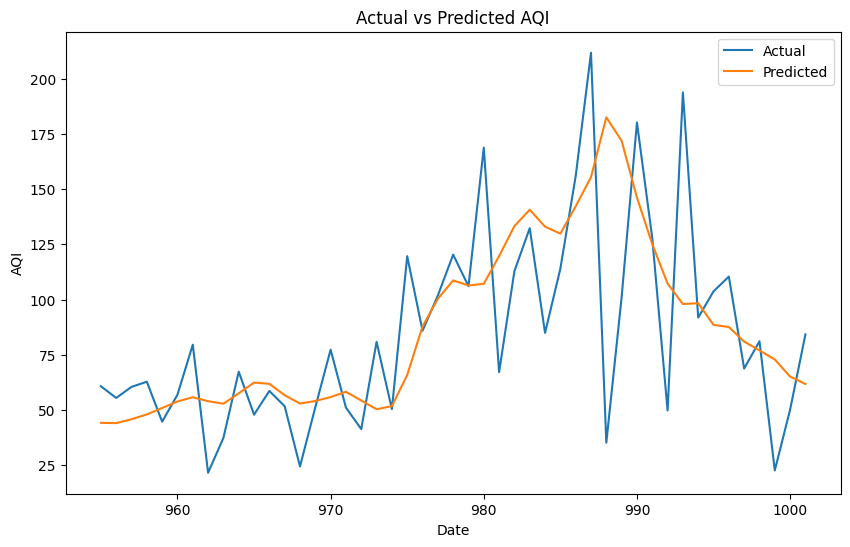

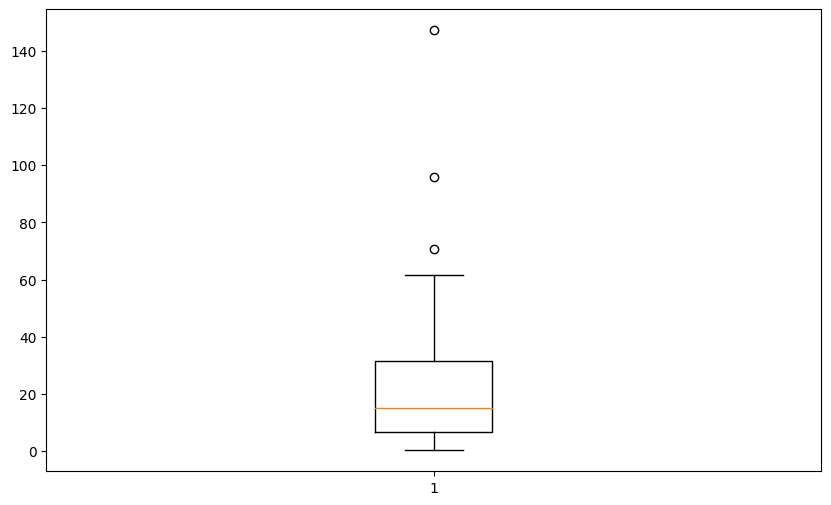

Errors for 7 days:
MAE: 25.946350749276117
RMSE: 34.554023458323236
R2: 0.481941291348953
SMAPE: 31.747344252950526


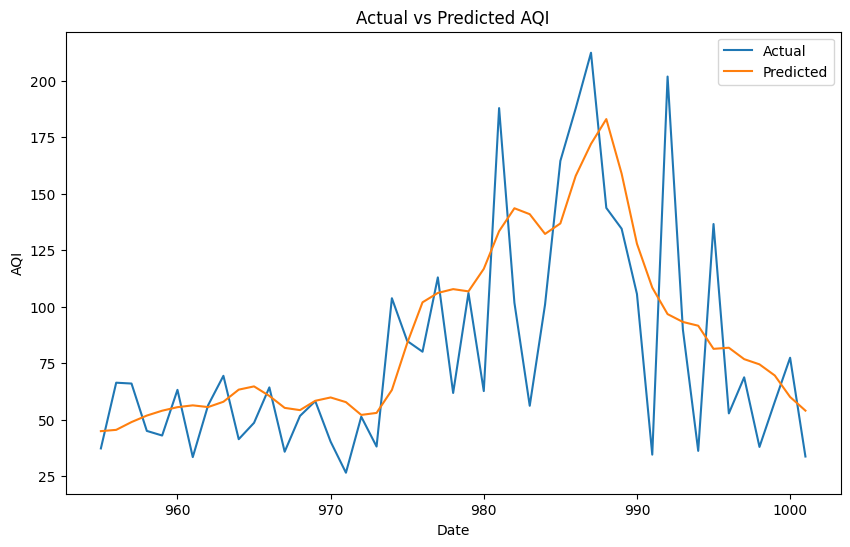

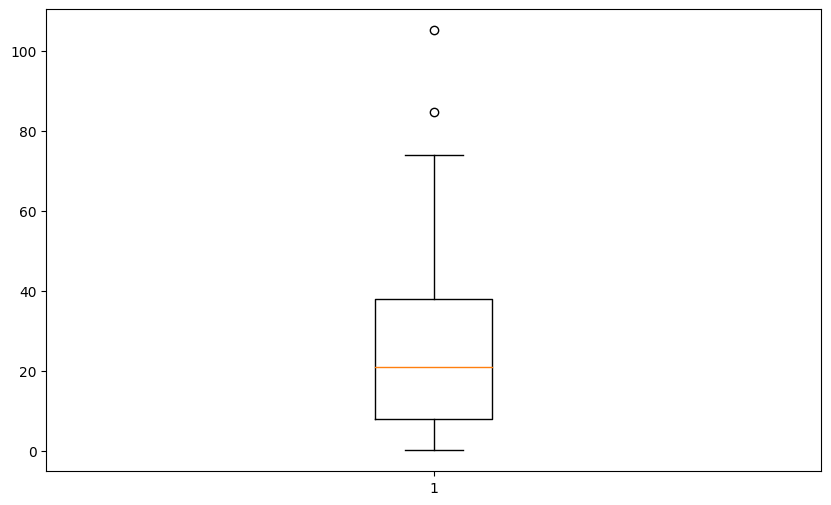

Errors for 14 days:
MAE: 26.027627077734344
RMSE: 34.60510126507455
R2: 0.4757801905664468
SMAPE: 31.619820909777786


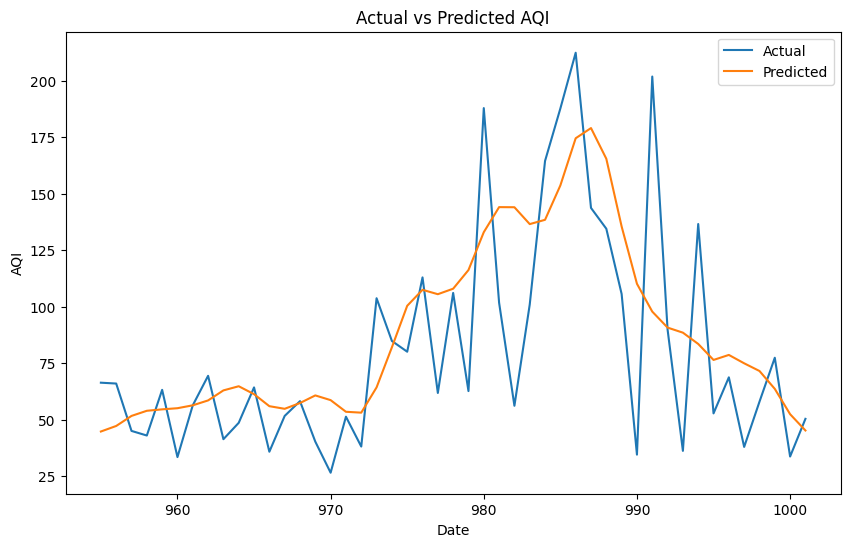

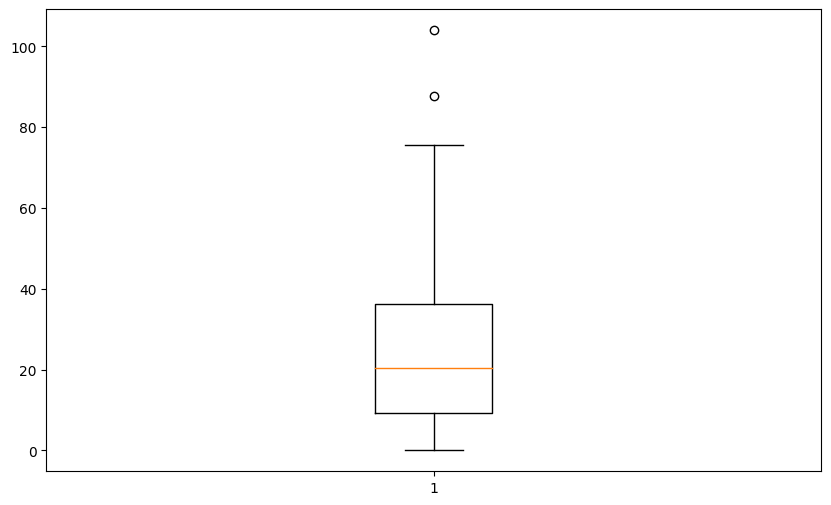

Errors for 28 days:
MAE: 25.72396815971134
RMSE: 34.568434936250966
R2: 0.4854306481569972
SMAPE: 31.09828940164547


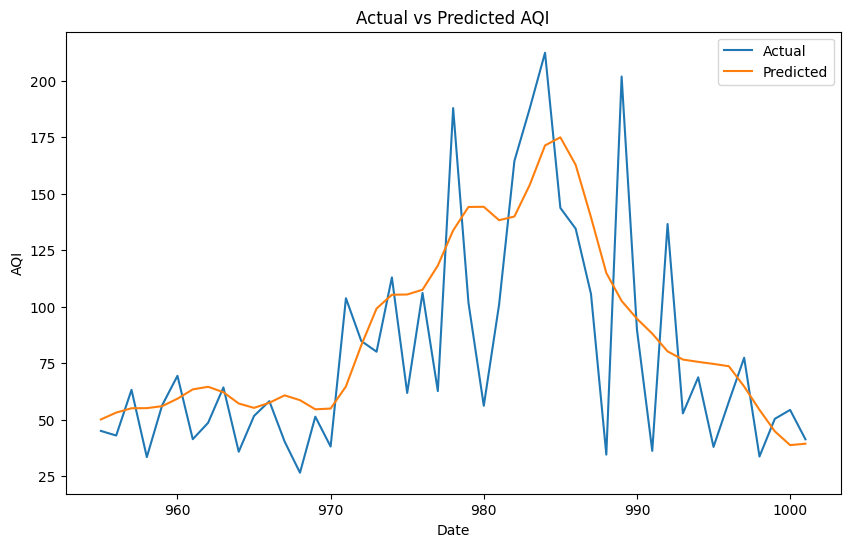

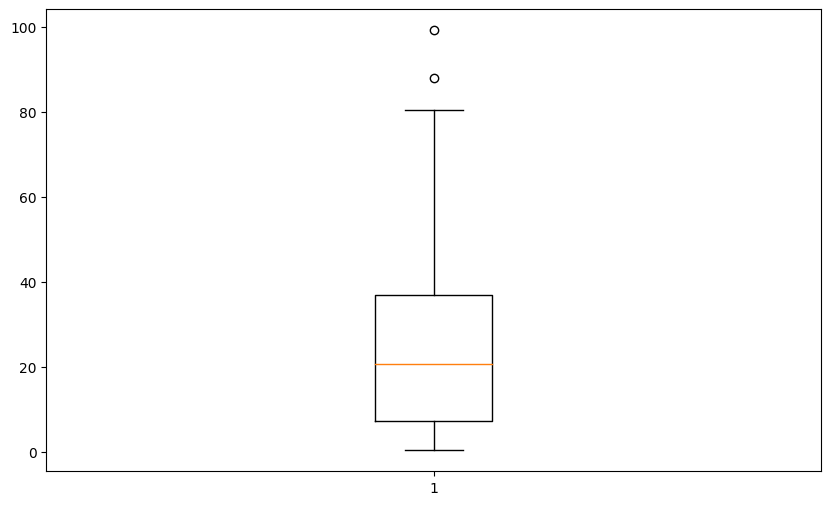


Results for dataset_aqi_hourly.csv with label AQI, train_size=48 months, test_size=28 days:

Errors for 1 days:
MAE: 29.77167607212293
RMSE: 38.00483976956326
R2: 0.4335237138530862
SMAPE: 40.529565314620825


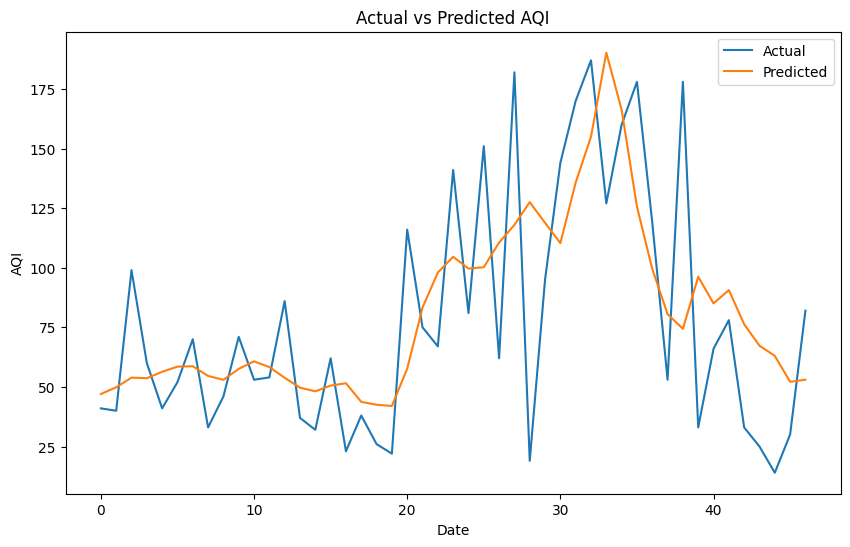

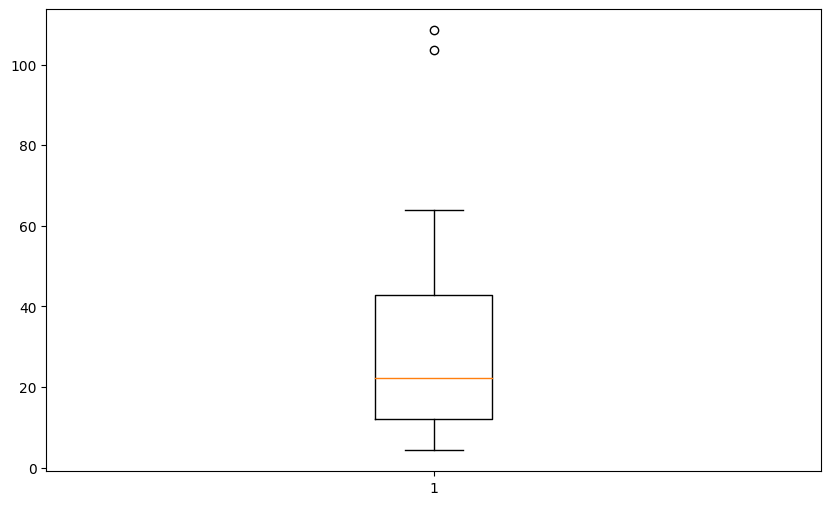

Errors for 7 days:
MAE: 27.029176806281153
RMSE: 40.44852233847119
R2: 0.44581724698657754
SMAPE: 28.7760599930644


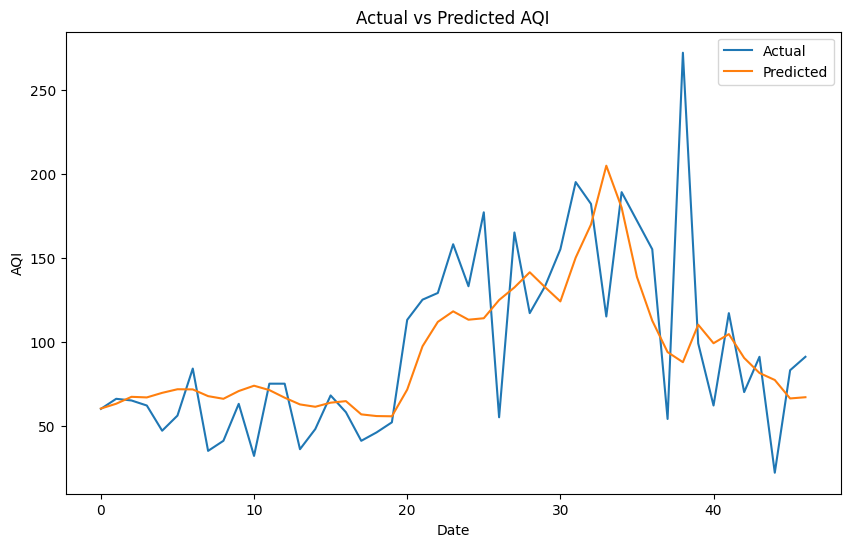

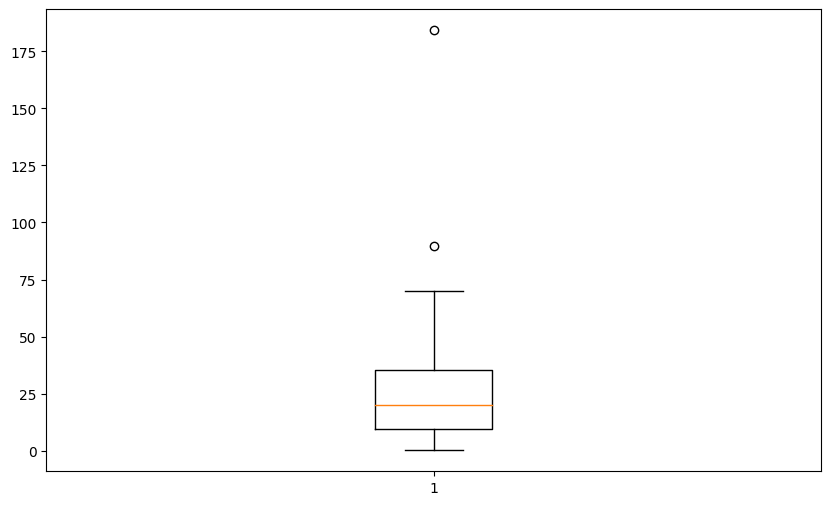

Errors for 14 days:
MAE: 27.460313760588193
RMSE: 41.40944871967229
R2: 0.1267236044311868
SMAPE: 36.21357782410469


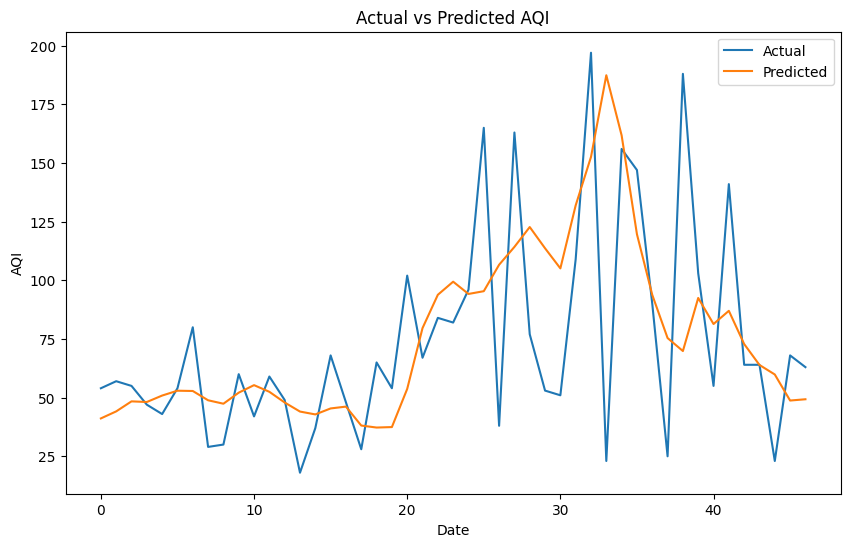

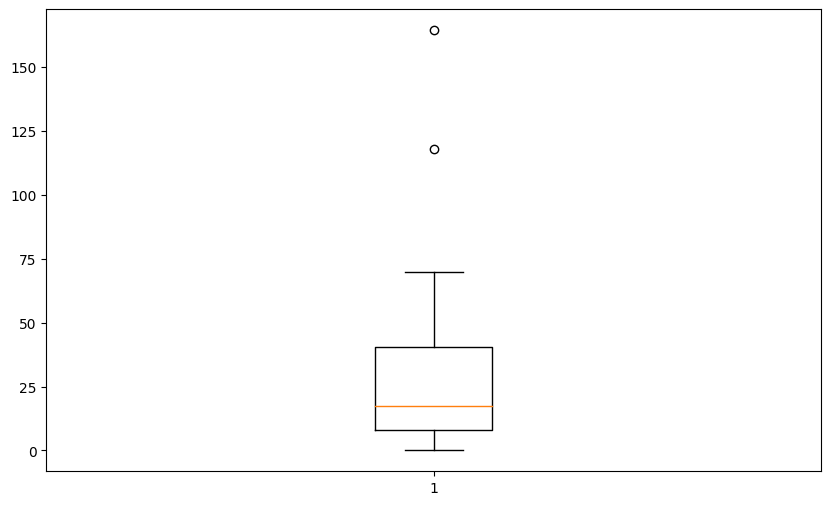

Errors for 28 days:
MAE: 34.227674284596326
RMSE: 46.84234526423529
R2: 0.31275358087844873
SMAPE: 36.59892355509332


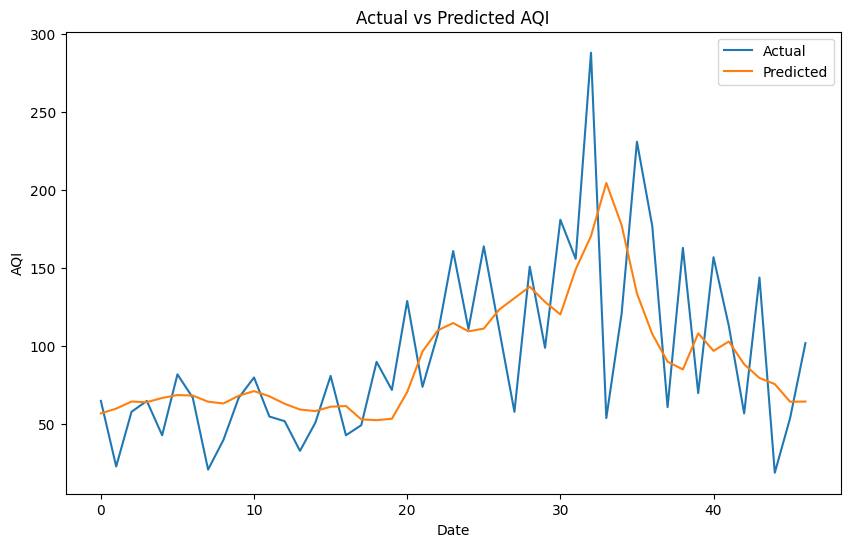

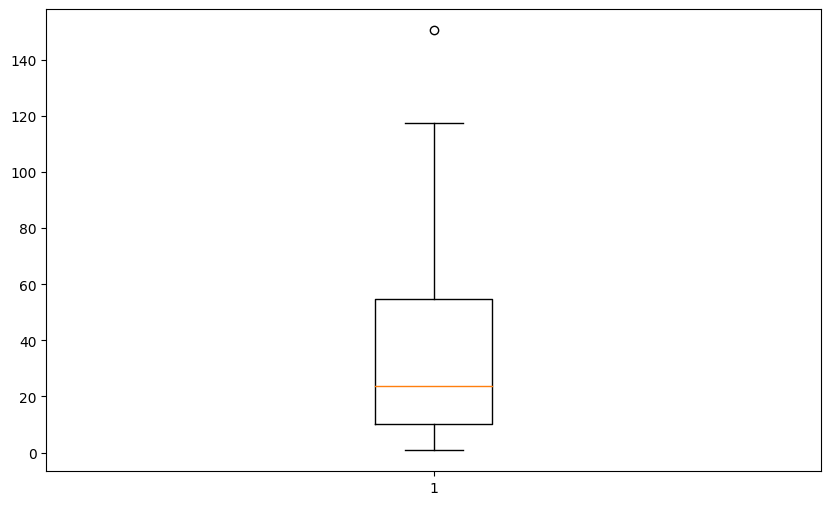


Results for dataset_aqi_daily_filled_with_neighbors.csv with label AQI, train_size=48 months, test_size=28 days:

Errors for 1 days:
MAE: 25.068478913944542
RMSE: 37.49495058950015
R2: 0.28441794702799095
SMAPE: 30.03106122363438


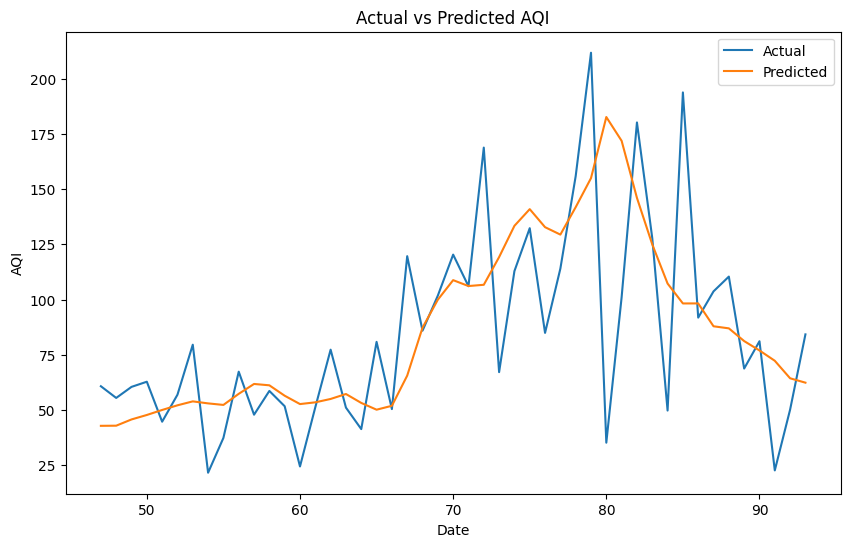

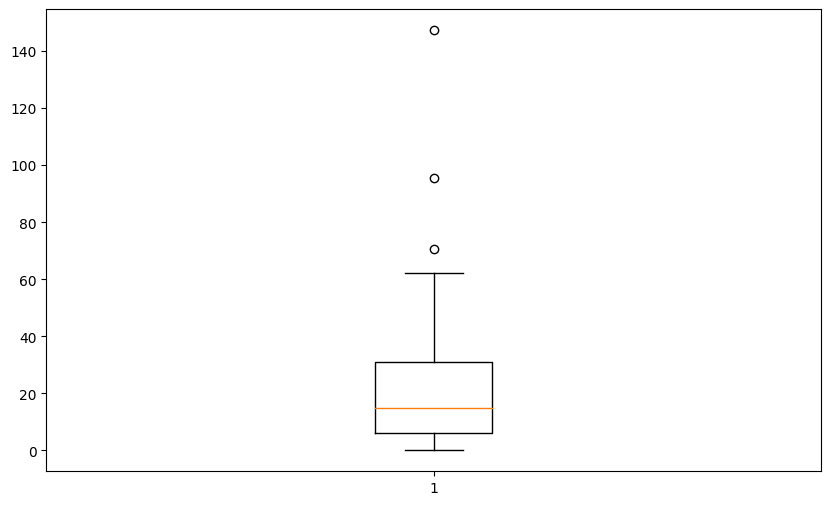

Errors for 7 days:
MAE: 25.83701947050392
RMSE: 34.50108610177235
R2: 0.4835274250785644
SMAPE: 31.57050398455529


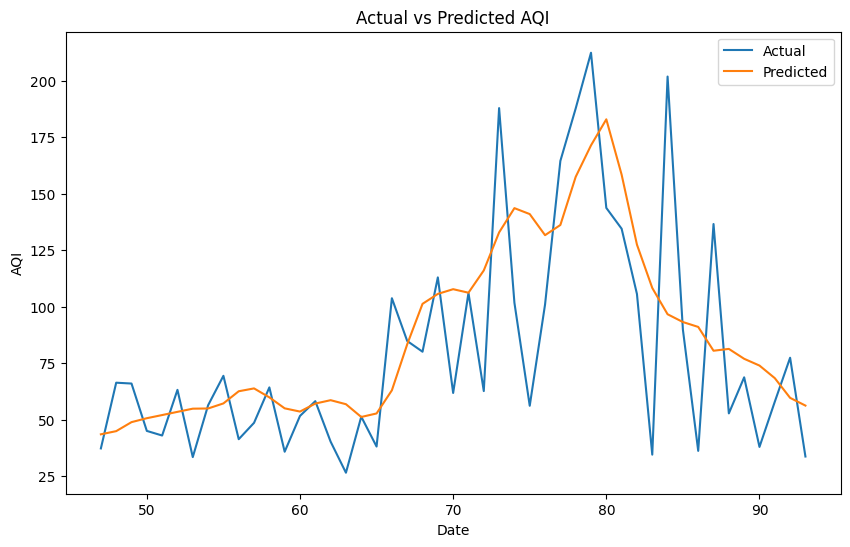

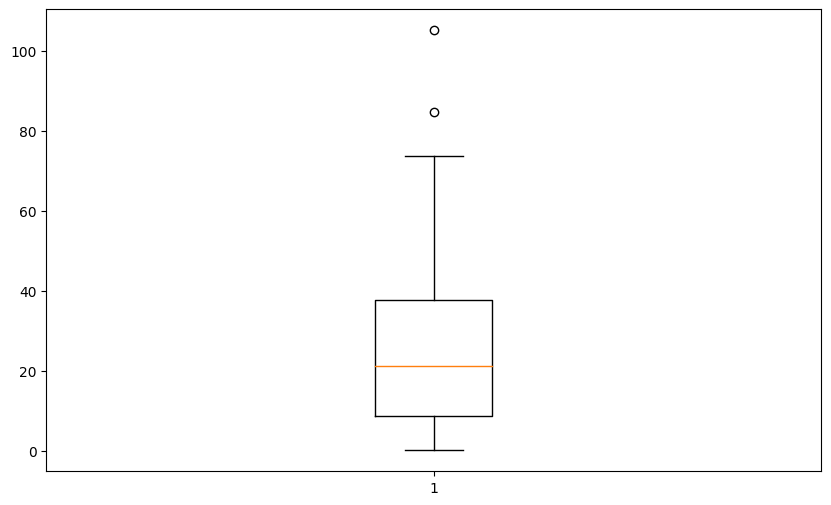

Errors for 14 days:
MAE: 25.802778034974352
RMSE: 34.48796958334484
R2: 0.4793229531838855
SMAPE: 31.261079895893676


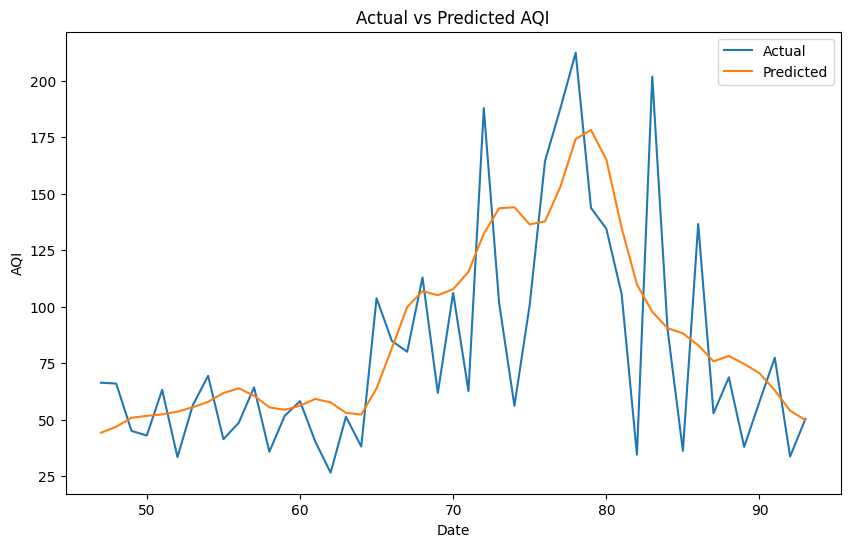

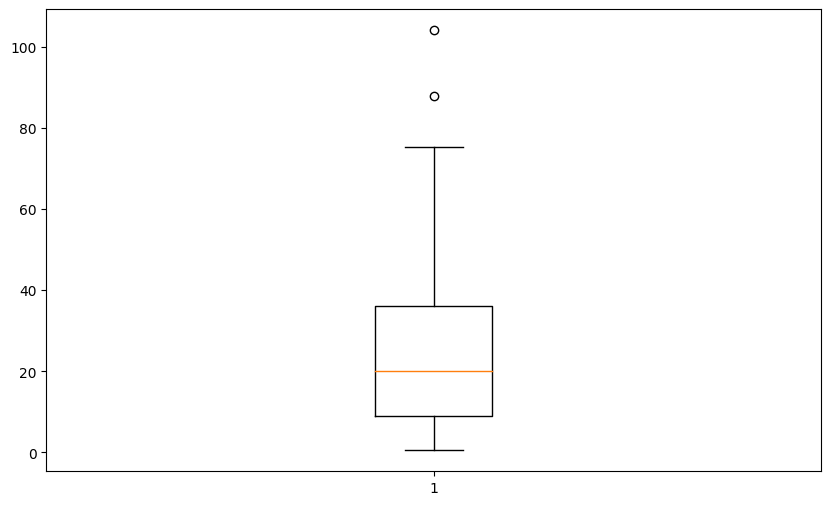

Errors for 28 days:
MAE: 25.343836772499333
RMSE: 34.33023255247752
R2: 0.49249775092115033
SMAPE: 30.45548105227368


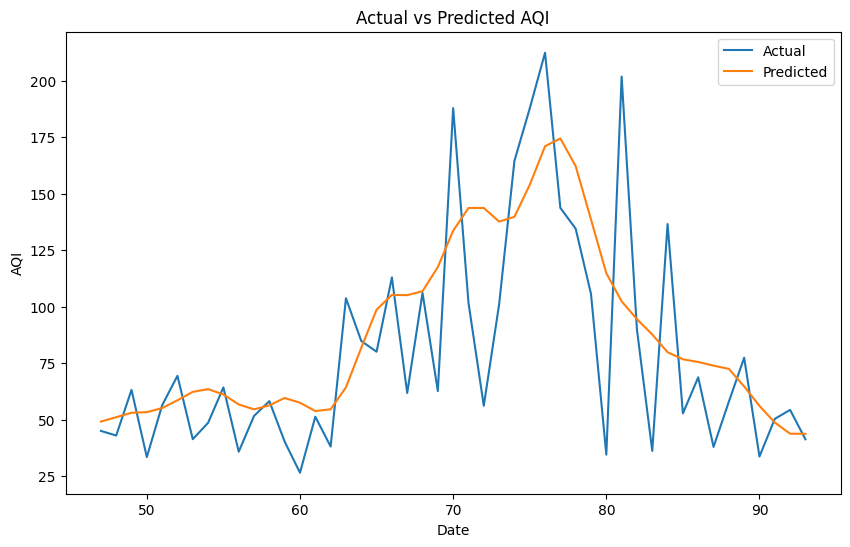

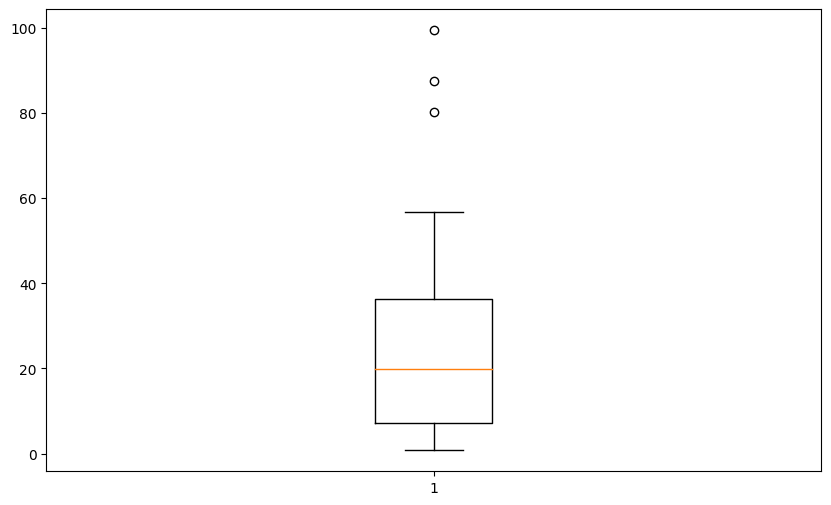


Results for dataset_aqi_hourly_filled_with_neighbors.csv with label AQI, train_size=48 months, test_size=28 days:

Errors for 1 days:
MAE: 29.499588671645373
RMSE: 37.85559348113565
R2: 0.4379641208739754
SMAPE: 40.10940315051813


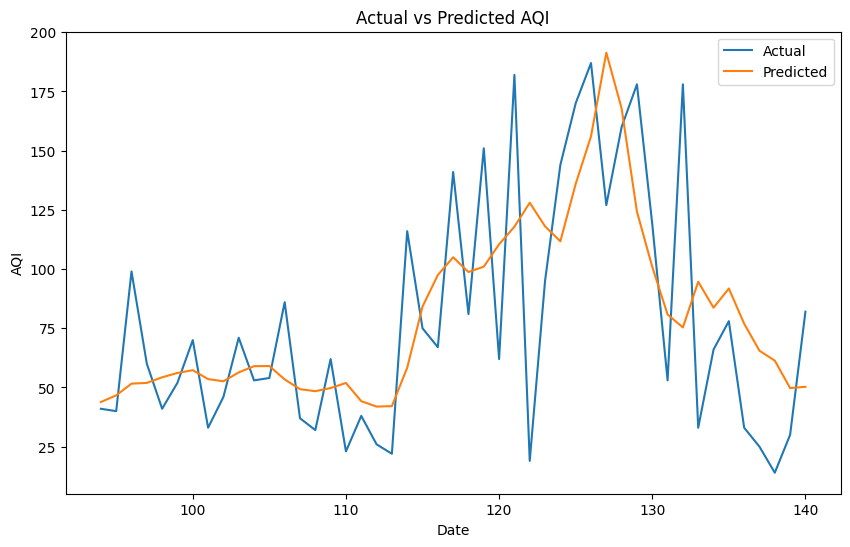

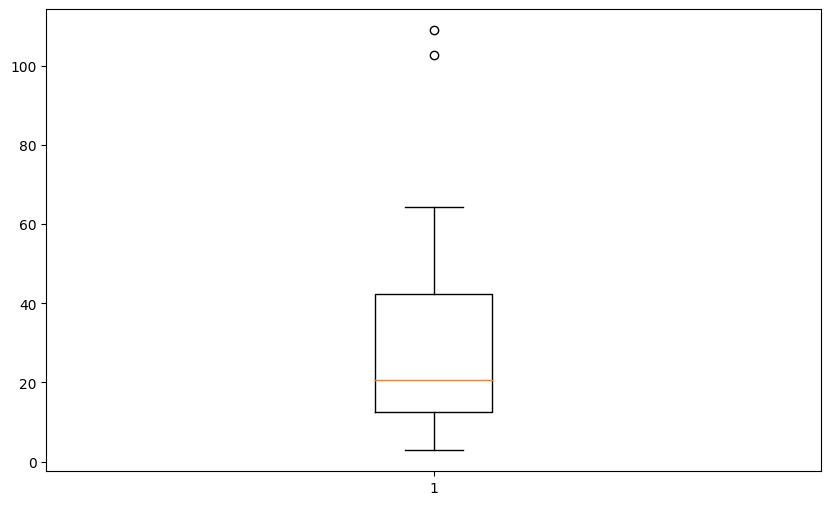

Errors for 7 days:
MAE: 26.835188243245696
RMSE: 40.16958648024325
R2: 0.45343425896461786
SMAPE: 28.7294573446661


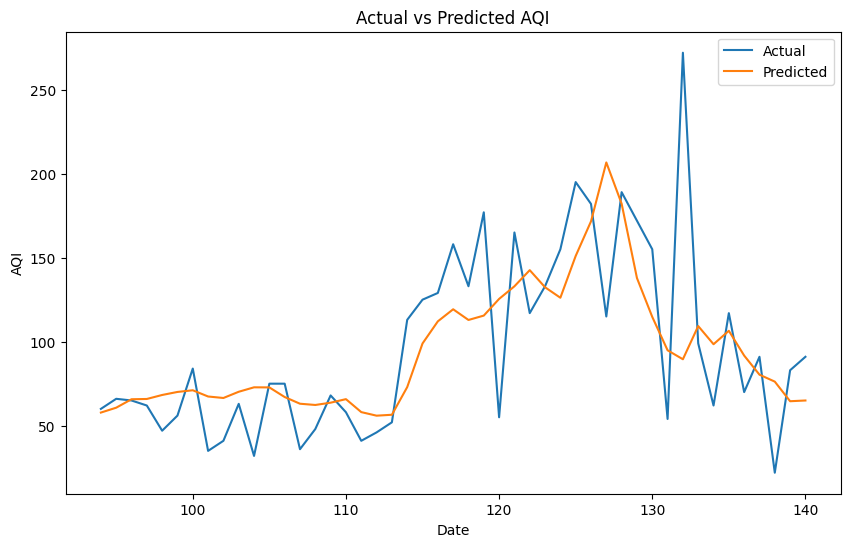

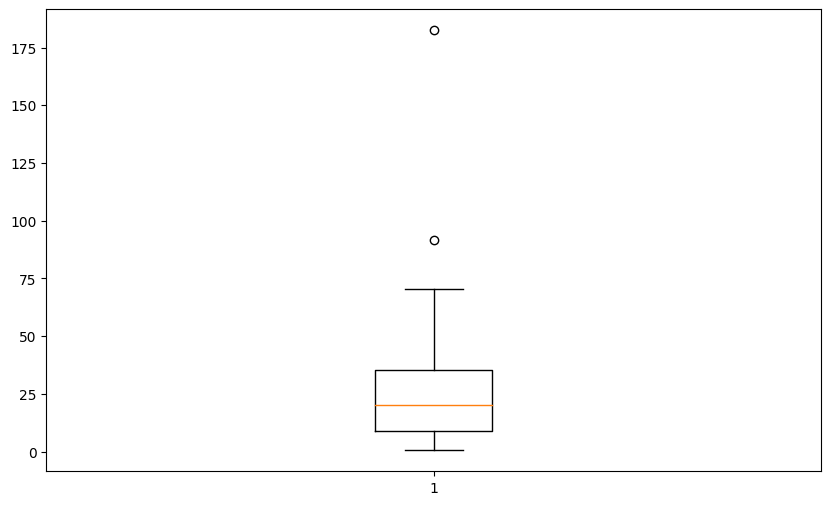

Errors for 14 days:
MAE: 27.858448328985396
RMSE: 41.48623530211265
R2: 0.12348192487509091
SMAPE: 36.948106752766144


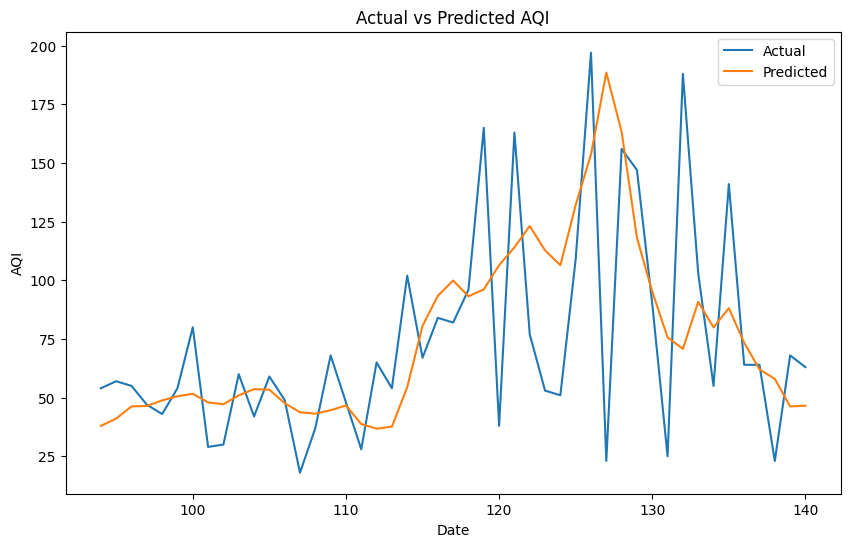

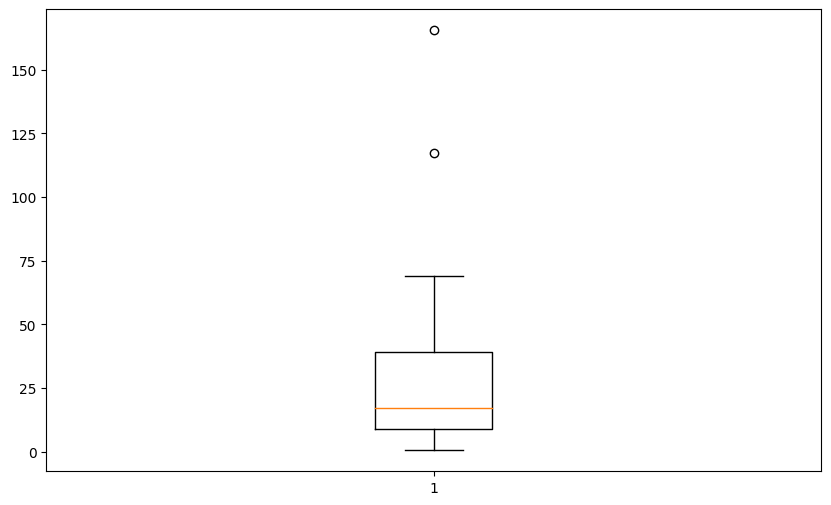

Errors for 28 days:
MAE: 34.3271702955213
RMSE: 46.79233530103659
R2: 0.31590941862366395
SMAPE: 36.881183985970964


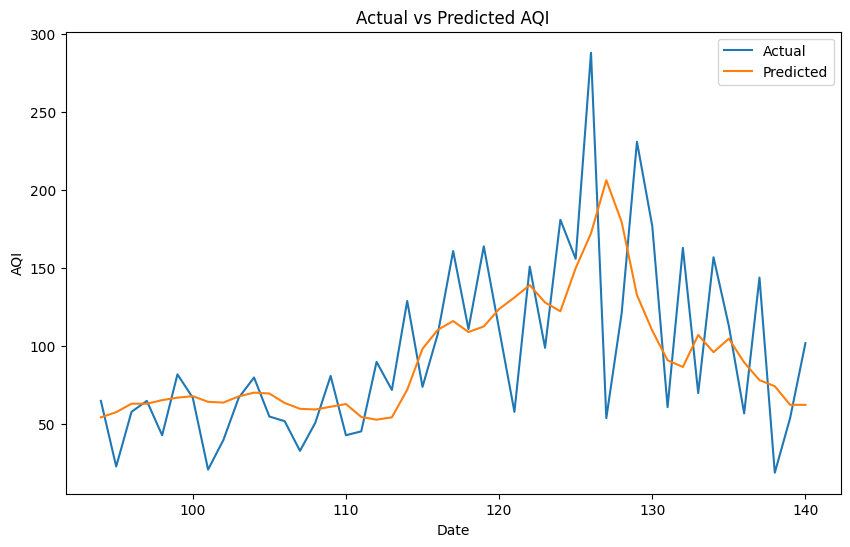

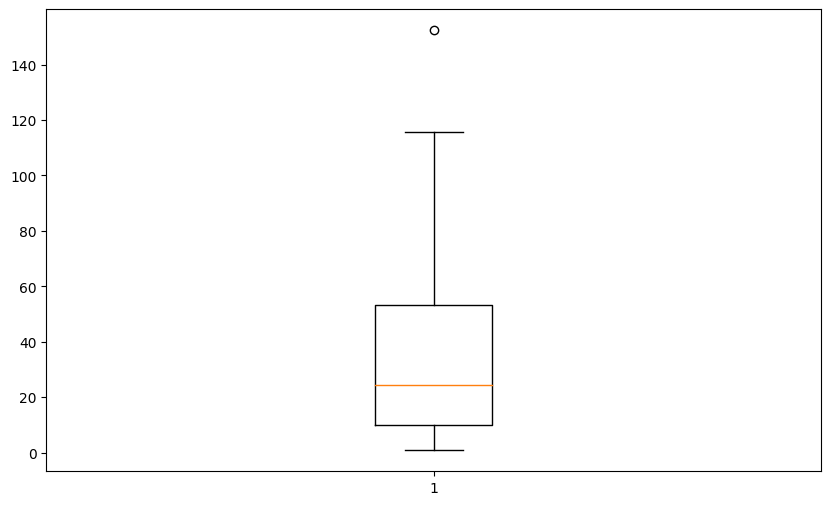


Results for dataset_aqi_daily.csv with label AQI, train_size=12 months, test_size=28 days:

Errors for 1 days:
MAE: 35.10369357860021
RMSE: 48.468773600207236
R2: 0.20438787512218115
SMAPE: 41.58528150294572


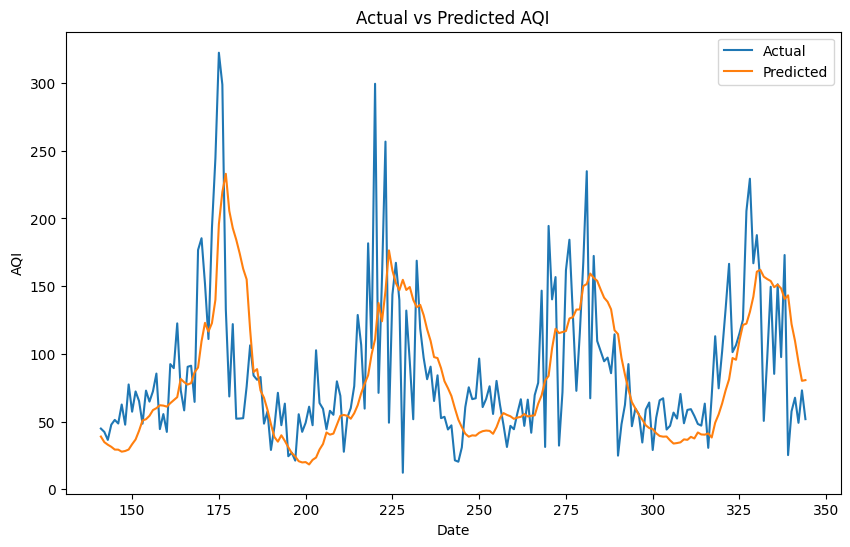

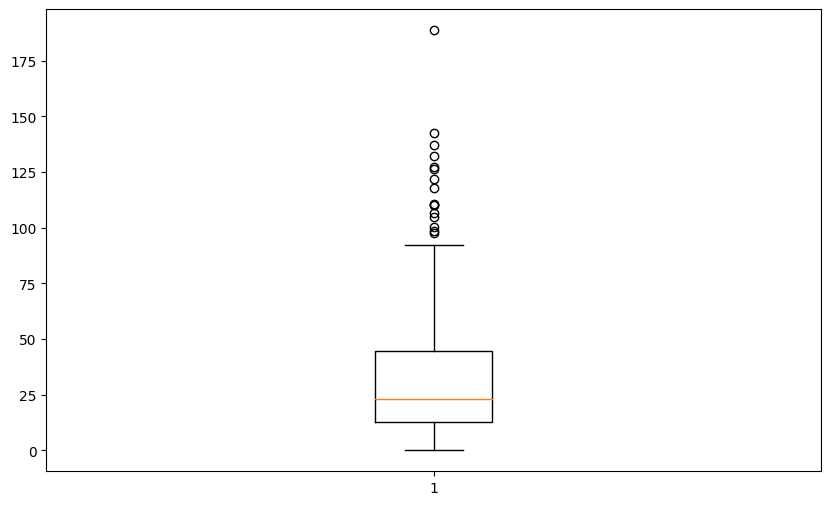

Errors for 7 days:
MAE: 38.11709049444435
RMSE: 52.47368316650972
R2: -0.04419493645293793
SMAPE: 46.65338221512766


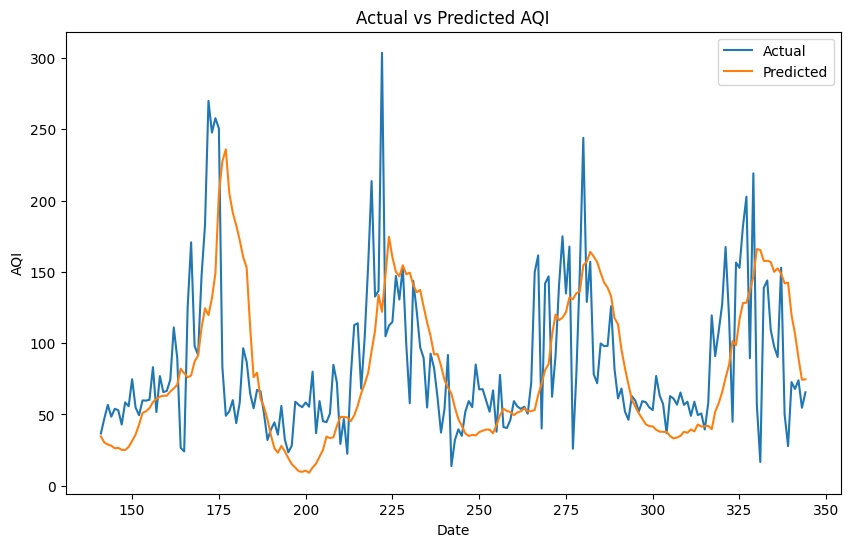

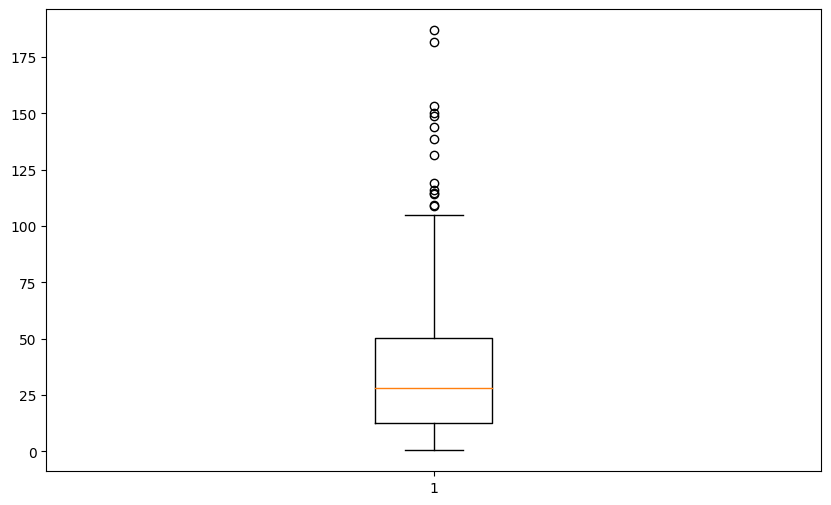

Errors for 14 days:
MAE: 42.90870462467644
RMSE: 57.176855537826455
R2: -0.23849401151736016
SMAPE: 53.79742817797986


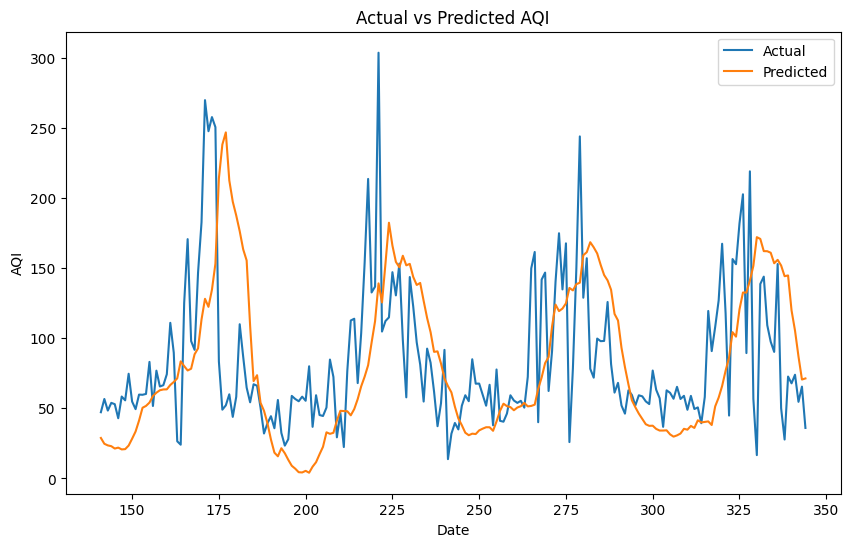

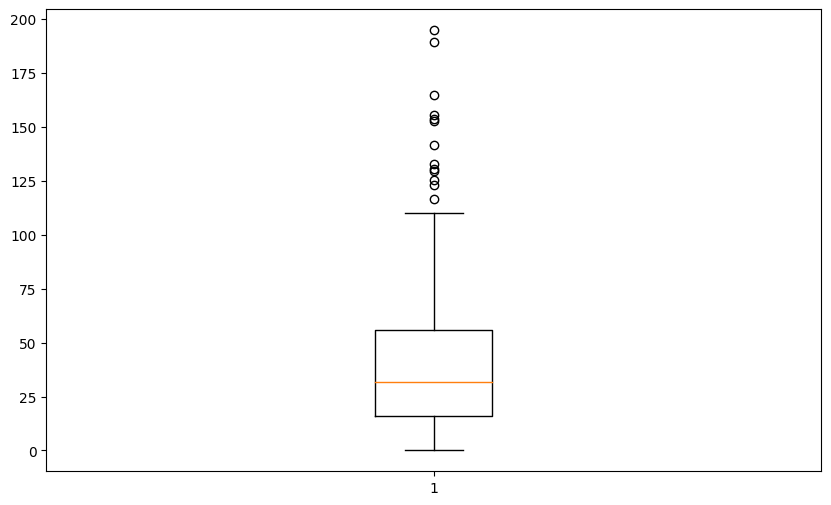

Errors for 28 days:
MAE: 51.84812258550035
RMSE: 66.12972458578685
R2: -0.6548685436401045
SMAPE: 68.66625027666798


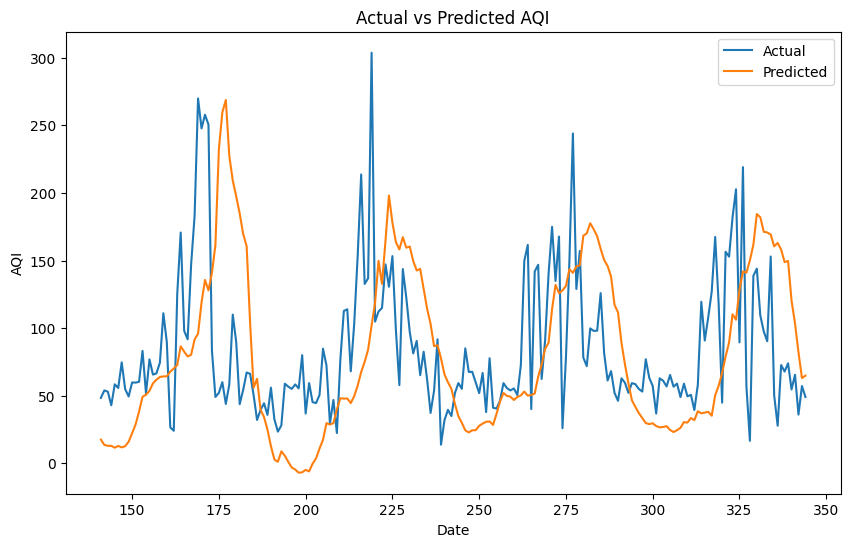

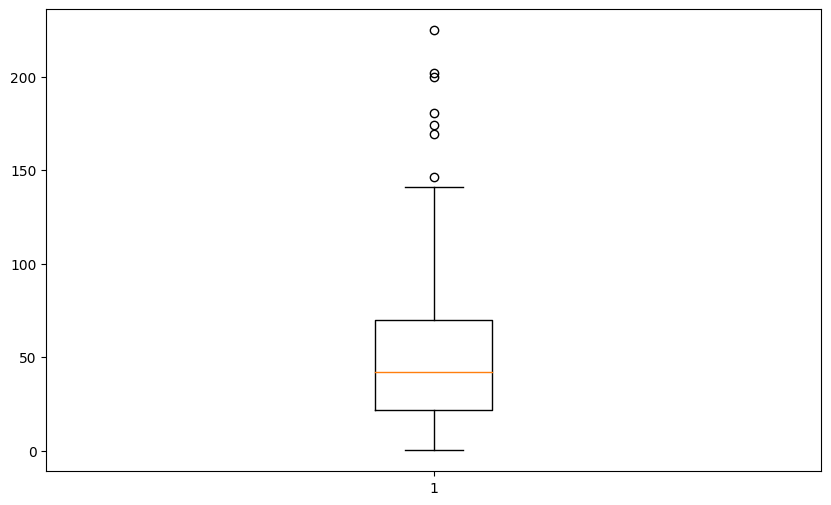


Results for dataset_aqi_hourly.csv with label AQI, train_size=12 months, test_size=28 days:

Errors for 1 days:
MAE: 34.62177155684574
RMSE: 51.59913540189927
R2: 0.31877800760189634
SMAPE: 42.9458437914512


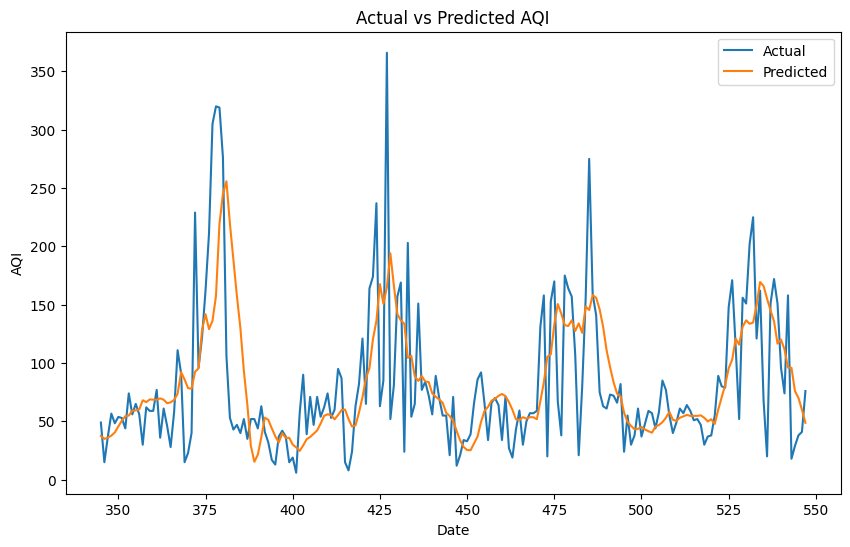

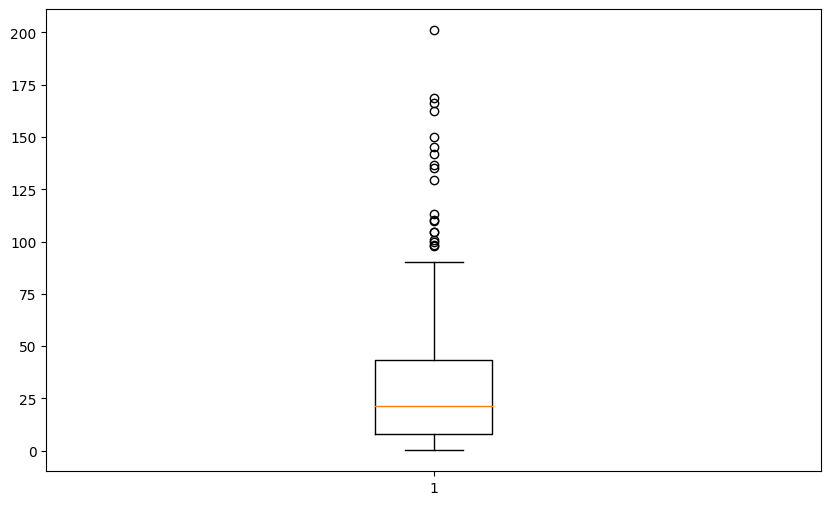

Errors for 7 days:
MAE: 36.087195741923736
RMSE: 53.41516290797691
R2: 0.32386839082224483
SMAPE: 36.82983803004076


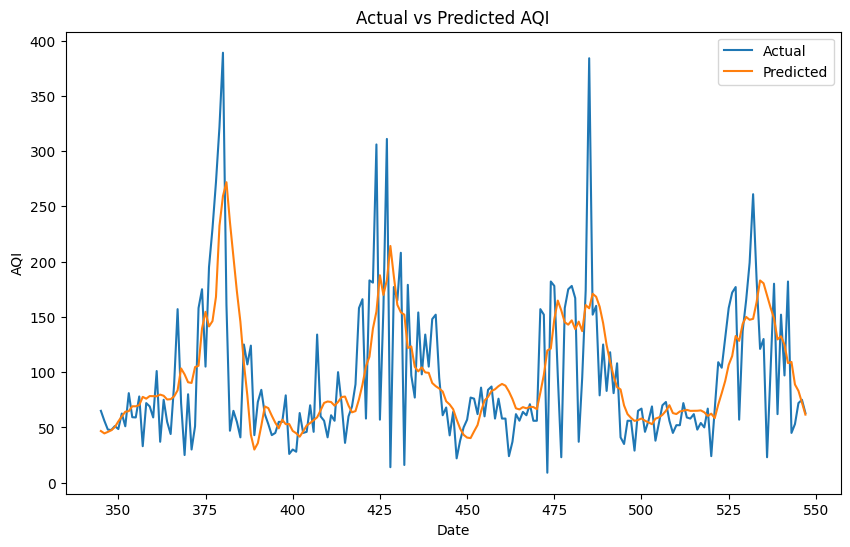

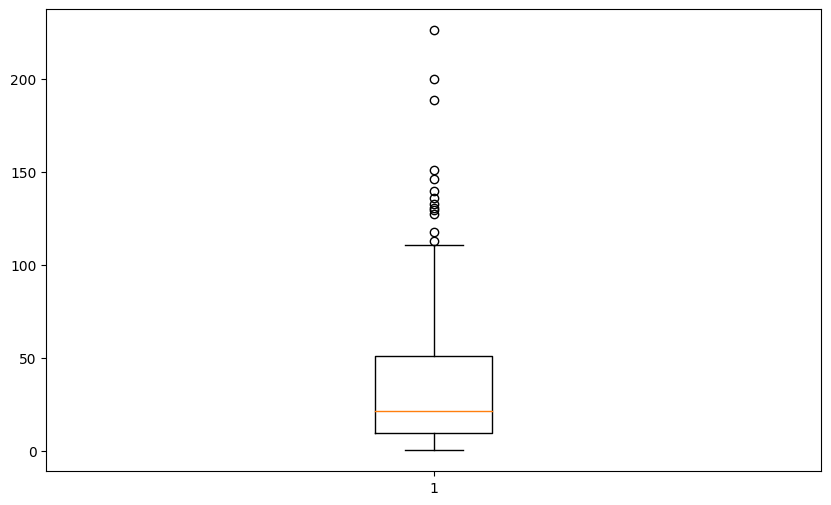

Errors for 14 days:
MAE: 30.821078218850342
RMSE: 44.95299906753175
R2: 0.25147708335369057
SMAPE: 41.41650863088527


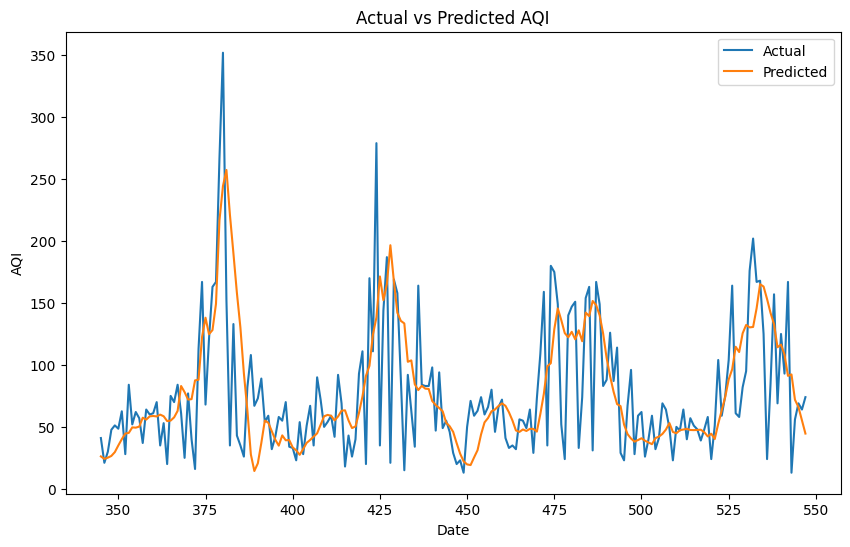

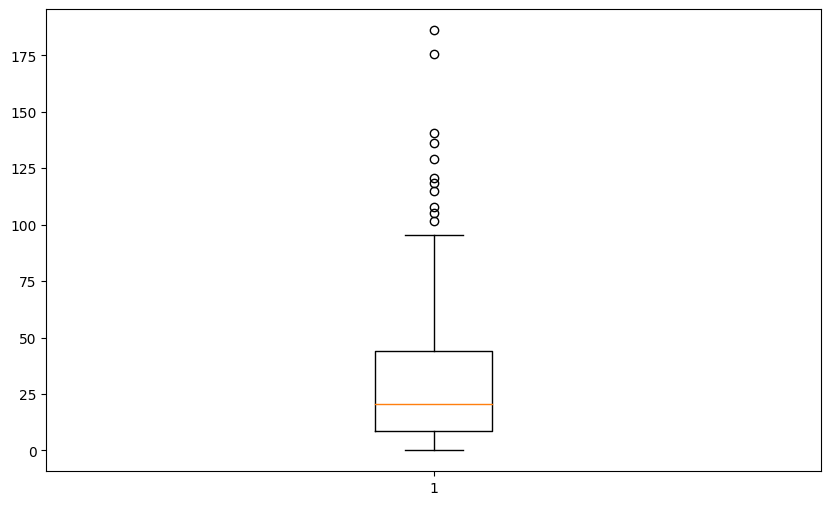

Errors for 28 days:
MAE: 38.01092207571537
RMSE: 55.21538025807959
R2: 0.3796105780111457
SMAPE: 39.4497014769482


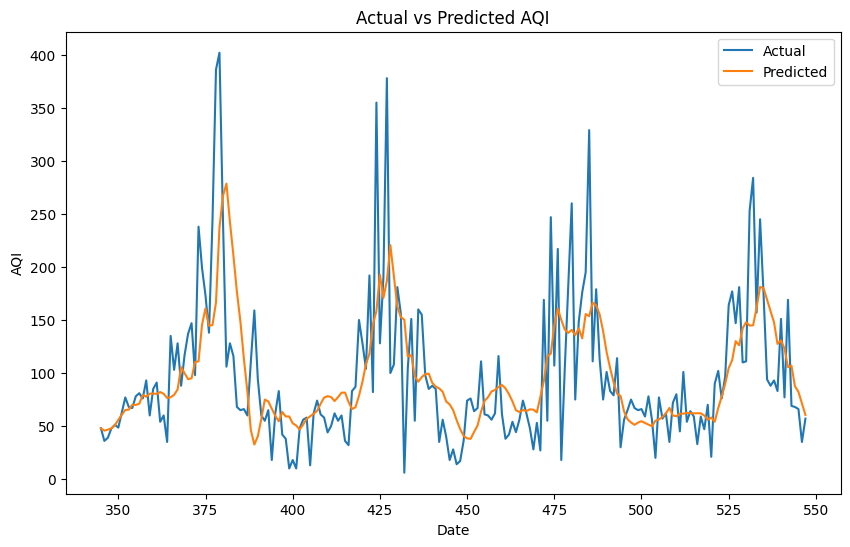

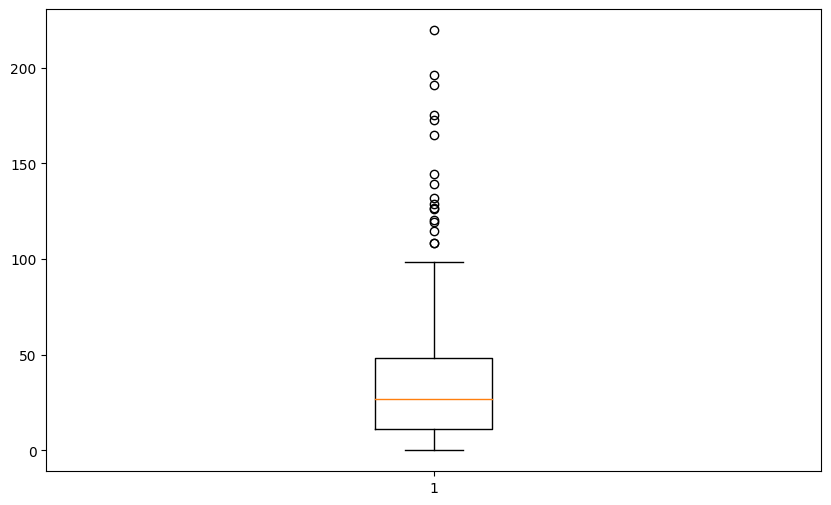


Results for dataset_aqi_daily_filled_with_neighbors.csv with label AQI, train_size=12 months, test_size=28 days:

Errors for 1 days:
MAE: 35.083123426607045
RMSE: 48.5368908744205
R2: 0.20178896747914843
SMAPE: 41.30461673484592


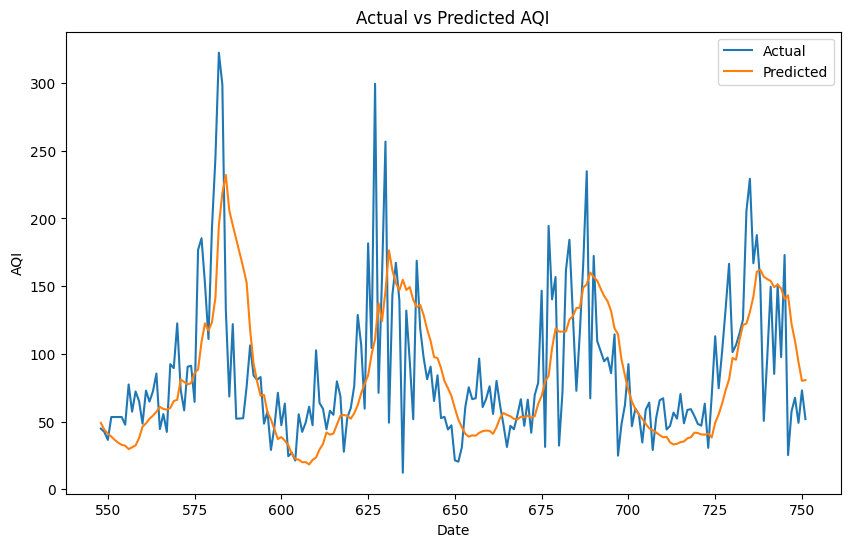

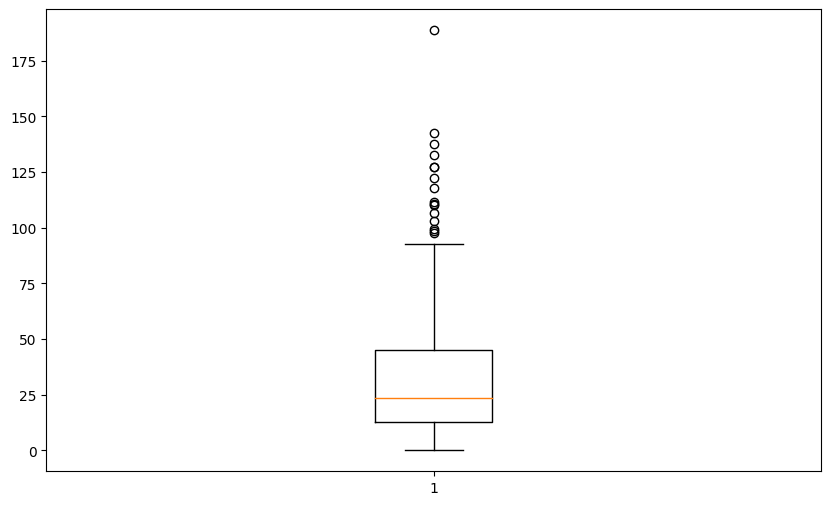

Errors for 7 days:
MAE: 38.05320795486852
RMSE: 52.470404210379684
R2: -0.043796434510045223
SMAPE: 46.205419537015395


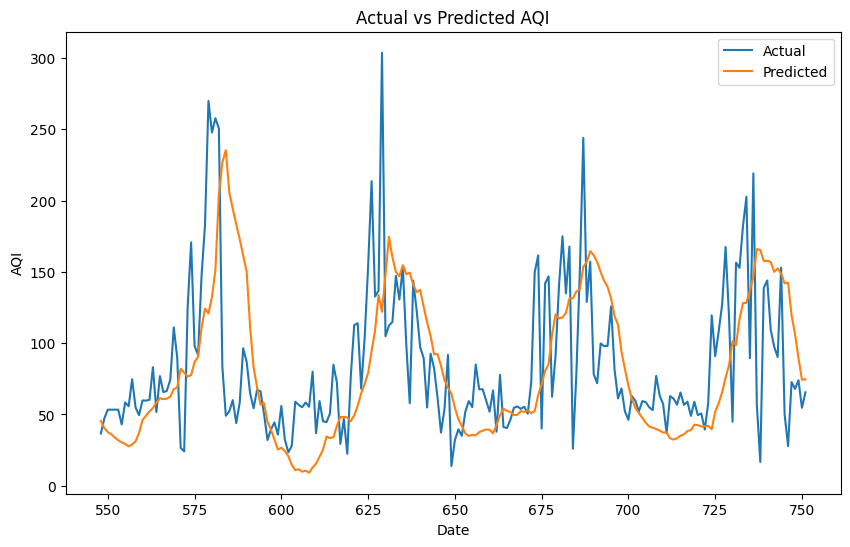

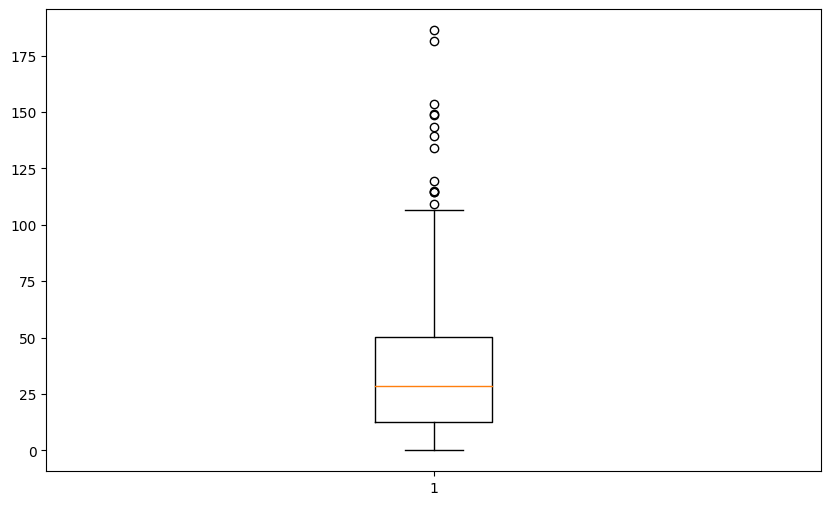

Errors for 14 days:
MAE: 42.6873960956784
RMSE: 57.09195439406387
R2: -0.23450168762190704
SMAPE: 52.90980092026473


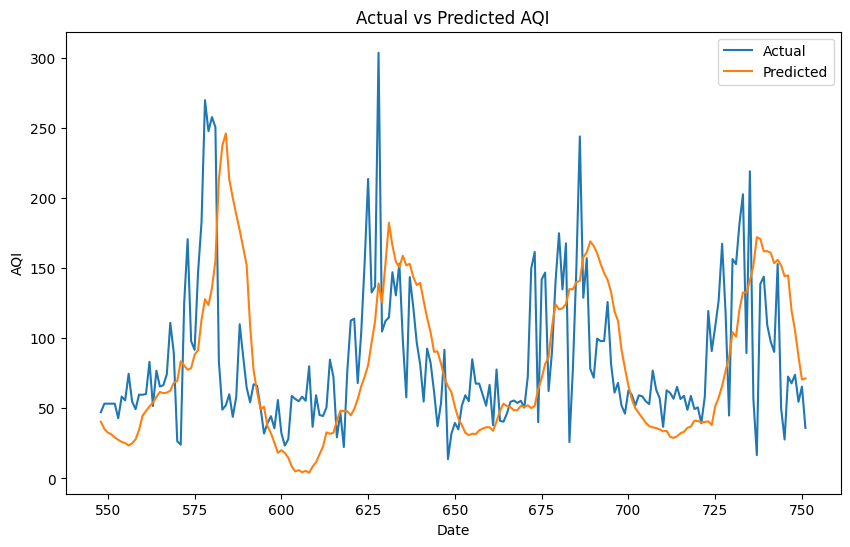

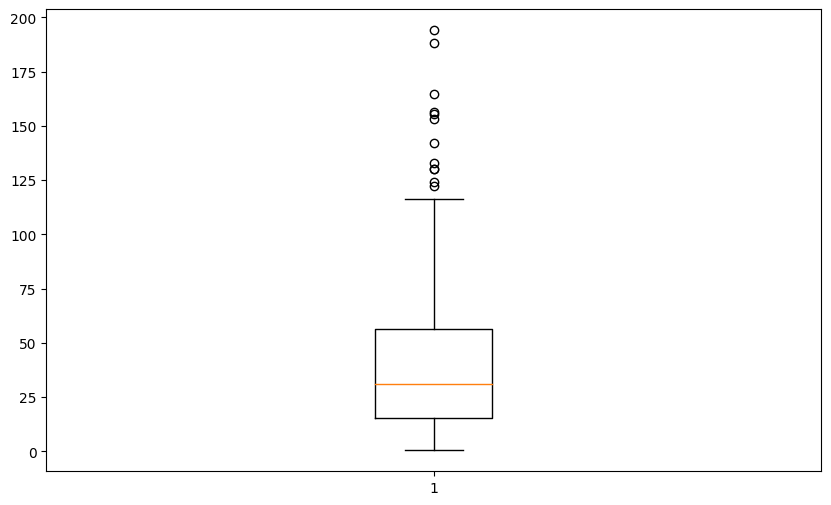

Errors for 28 days:
MAE: 51.69364399615289
RMSE: 66.05686580584845
R2: -0.6514032926697848
SMAPE: 67.2532775022789


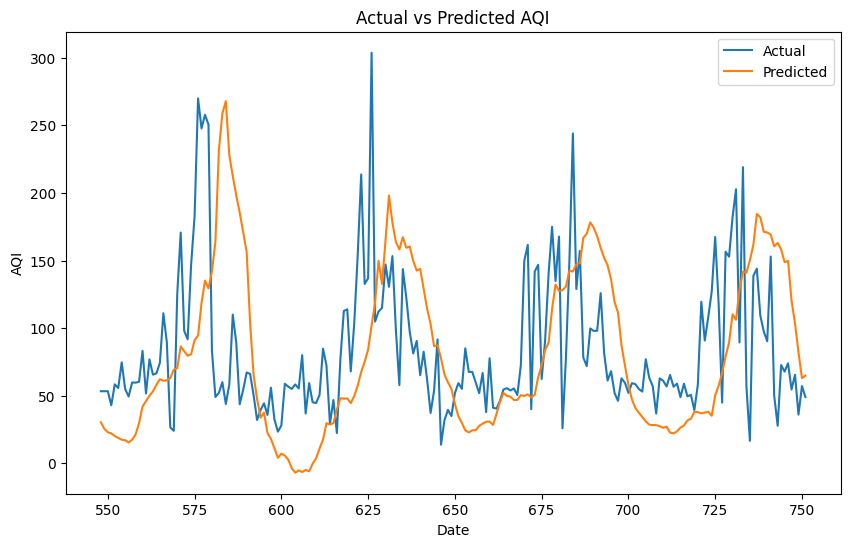

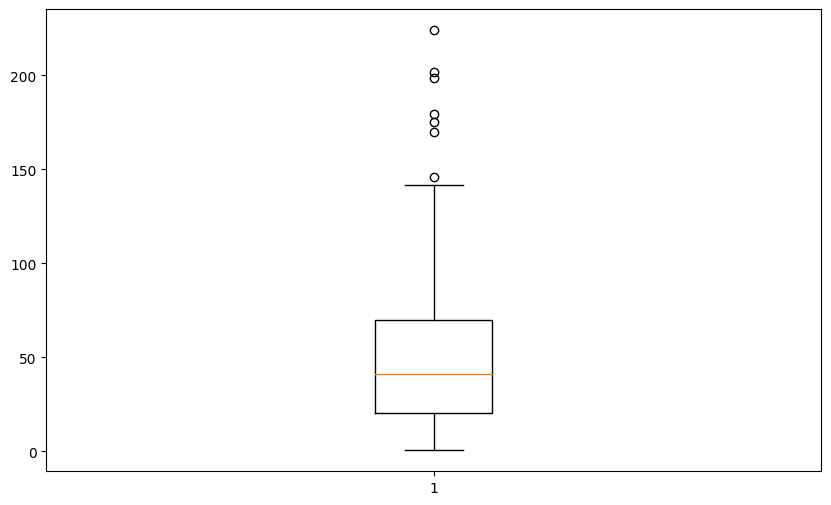


Results for dataset_aqi_hourly_filled_with_neighbors.csv with label AQI, train_size=12 months, test_size=28 days:

Errors for 1 days:
MAE: 34.50670548191783
RMSE: 51.592385055428764
R2: 0.3200021626711069
SMAPE: 42.89454975022556


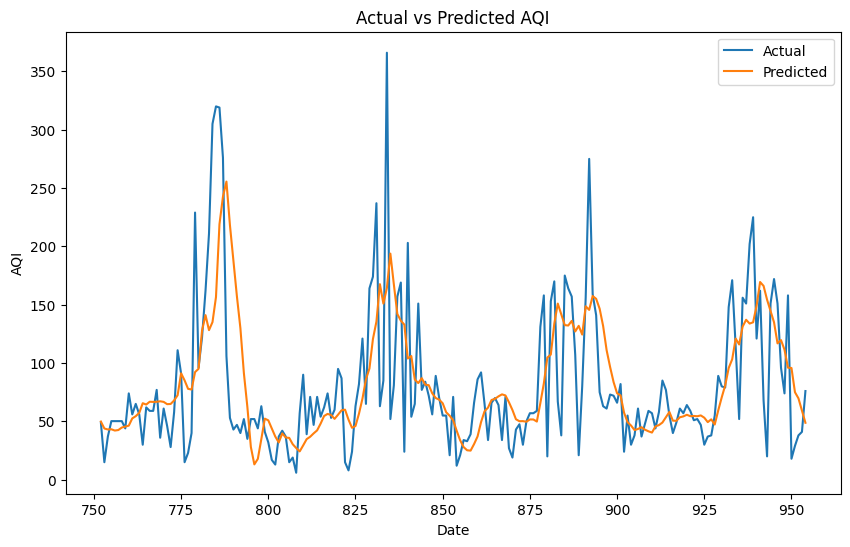

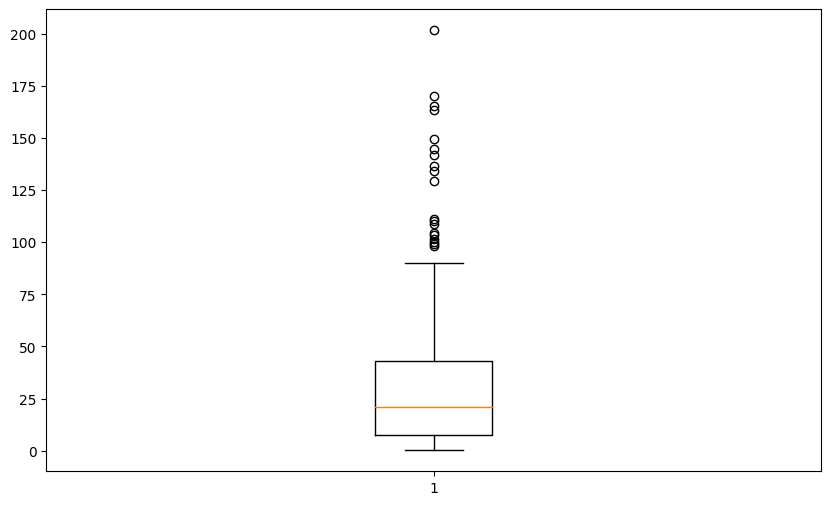

Errors for 7 days:
MAE: 36.116630328666595
RMSE: 53.48926760241159
R2: 0.3197887456626327
SMAPE: 36.78947038332125


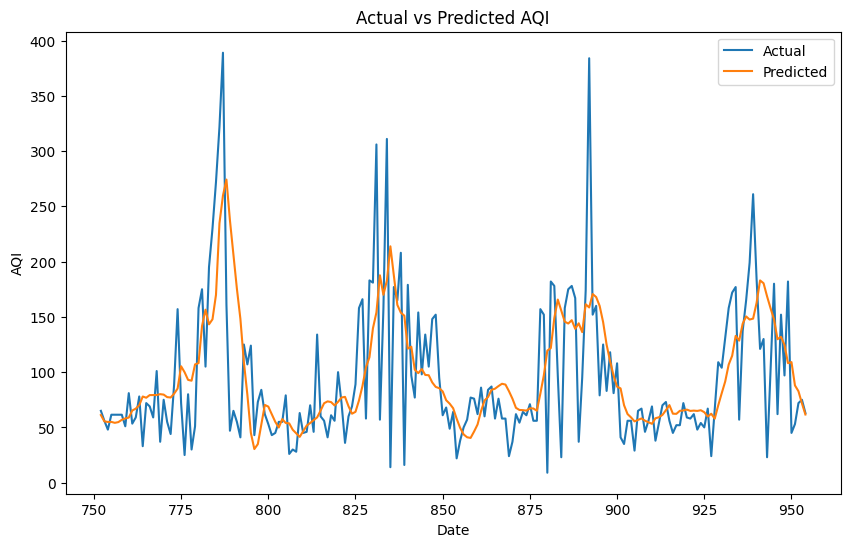

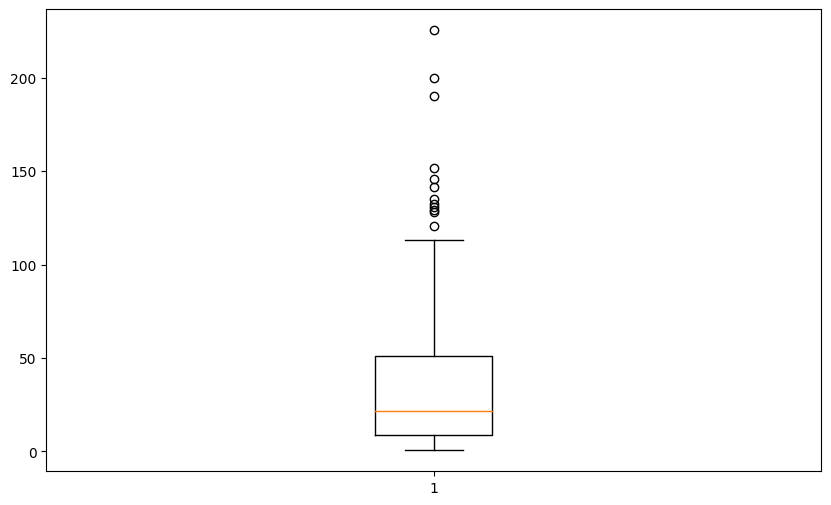

Errors for 14 days:
MAE: 30.80001242448019
RMSE: 44.95481183561205
R2: 0.25367667986199327
SMAPE: 41.4227887773966


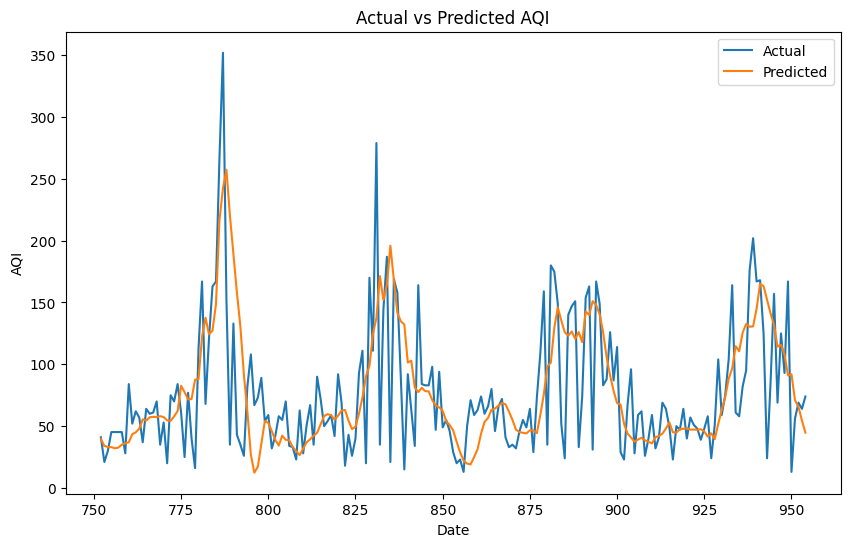

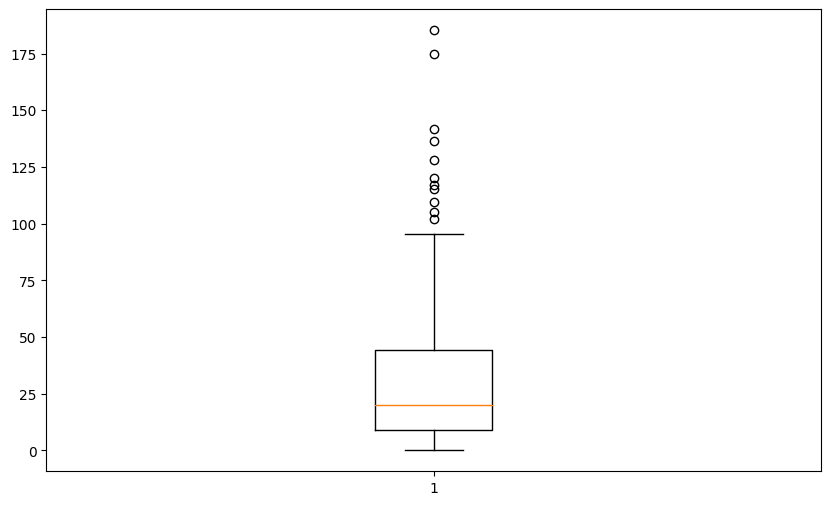

Errors for 28 days:
MAE: 38.39484507144102
RMSE: 55.30002113166745
R2: 0.37549656808333987
SMAPE: 40.07491840729722


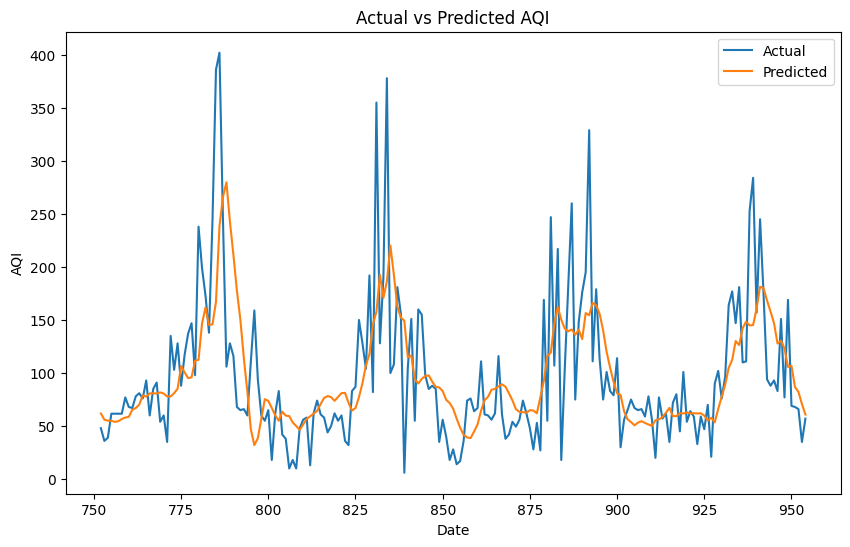

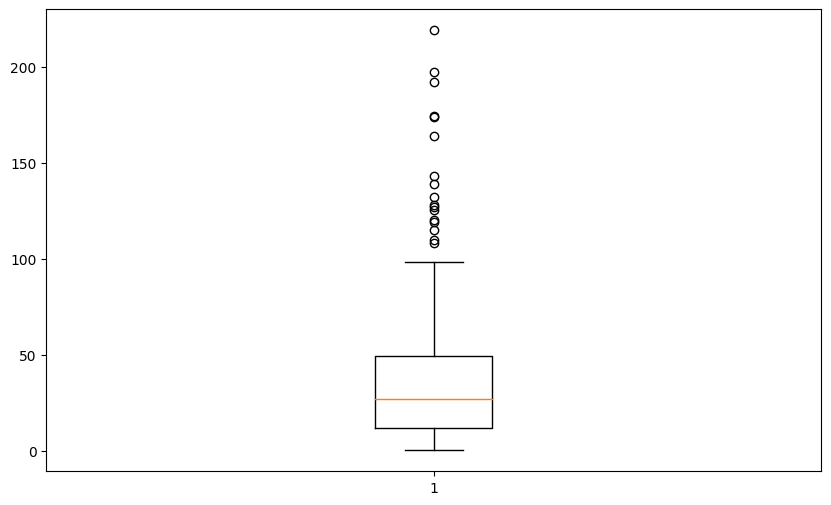


Results for dataset_aqi_daily.csv with label AQI, train_size=6.0 months, test_size=28 days:

Errors for 1 days:
MAE: 33.18035284786911
RMSE: 48.40912059038584
R2: 0.294767520859467
SMAPE: 37.70901655334231


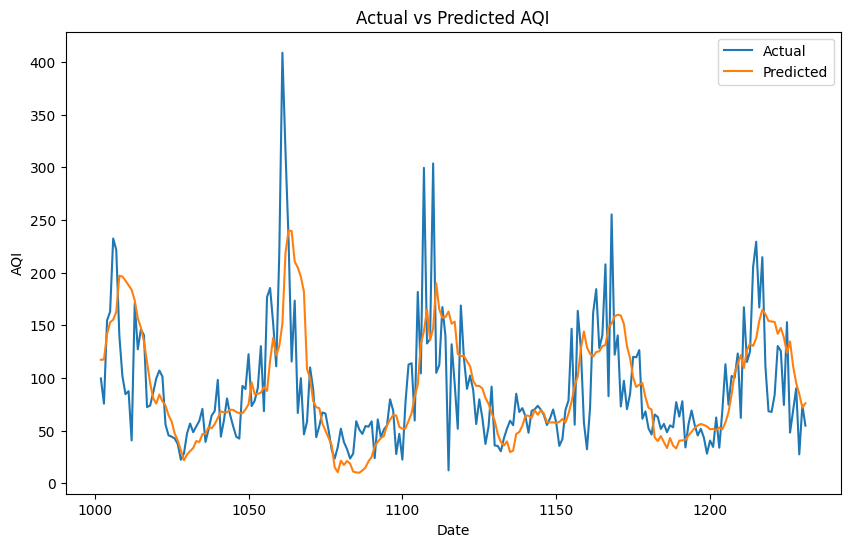

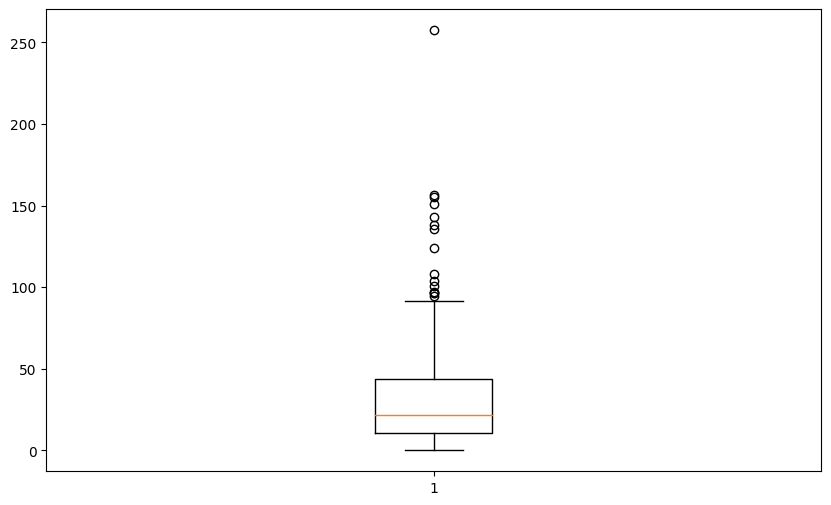

Errors for 7 days:
MAE: 35.591016429151736
RMSE: 49.218204108227326
R2: 0.1494662252728709
SMAPE: 45.54120604491067


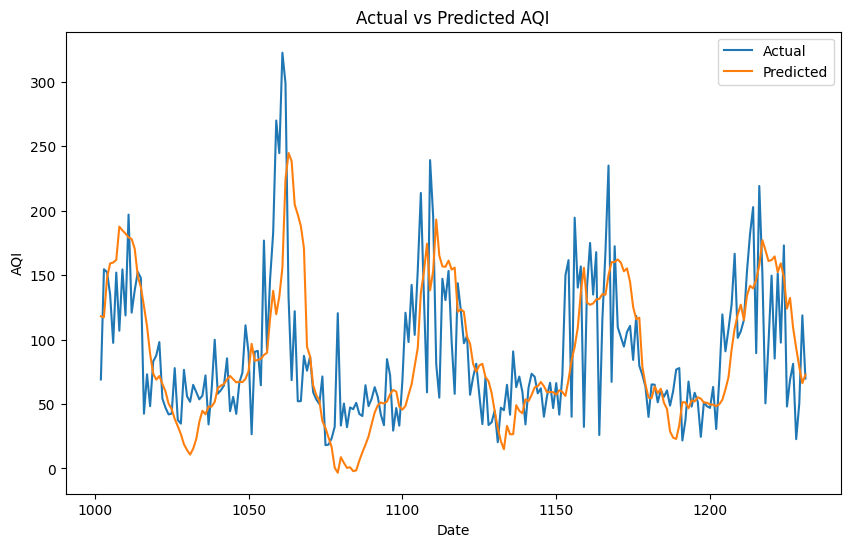

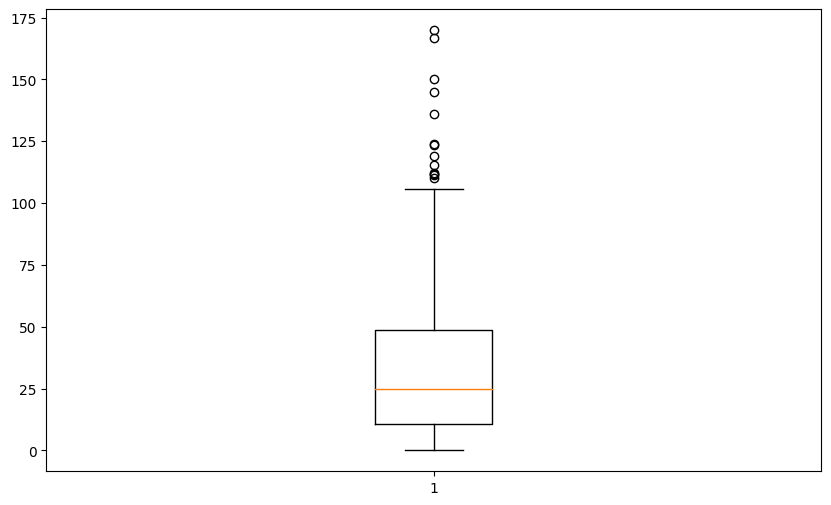

Errors for 14 days:
MAE: 41.006199017264116
RMSE: 55.55484315044487
R2: 0.005843605993046563
SMAPE: 52.268265948042455


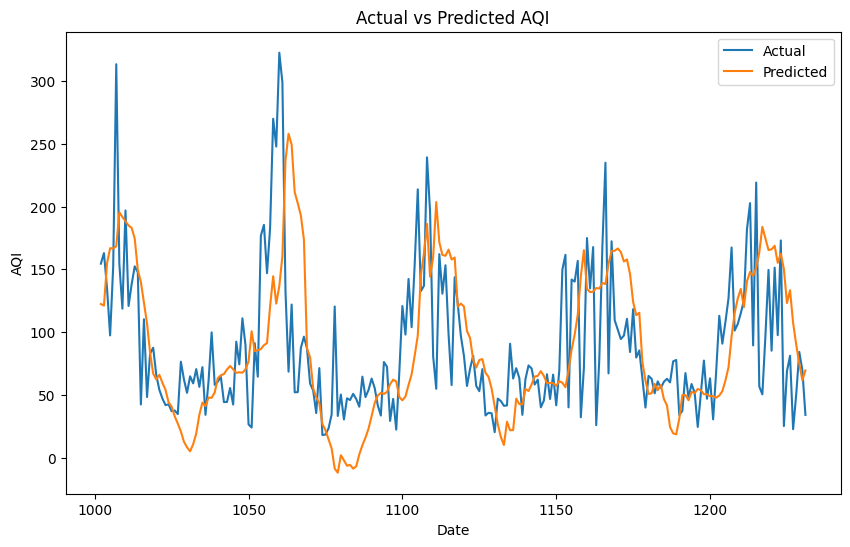

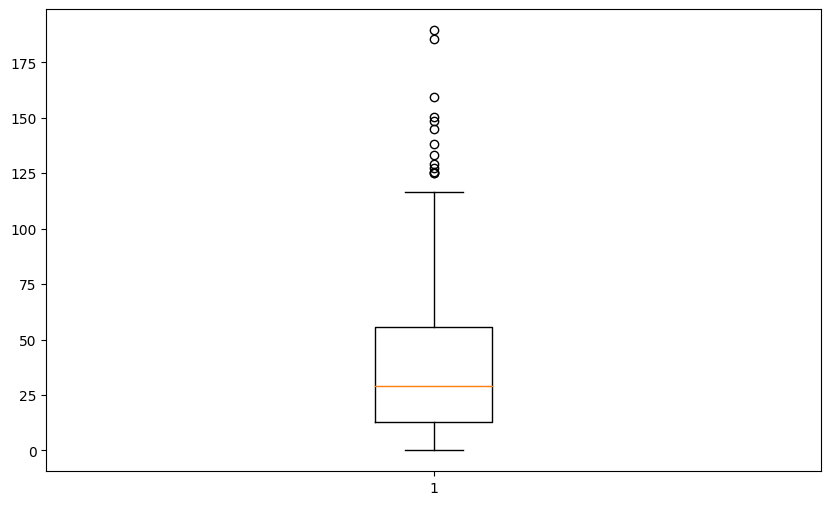

Errors for 28 days:
MAE: 48.245077060691585
RMSE: 62.71285458243177
R2: -0.2492891833496873
SMAPE: 63.14685834168833


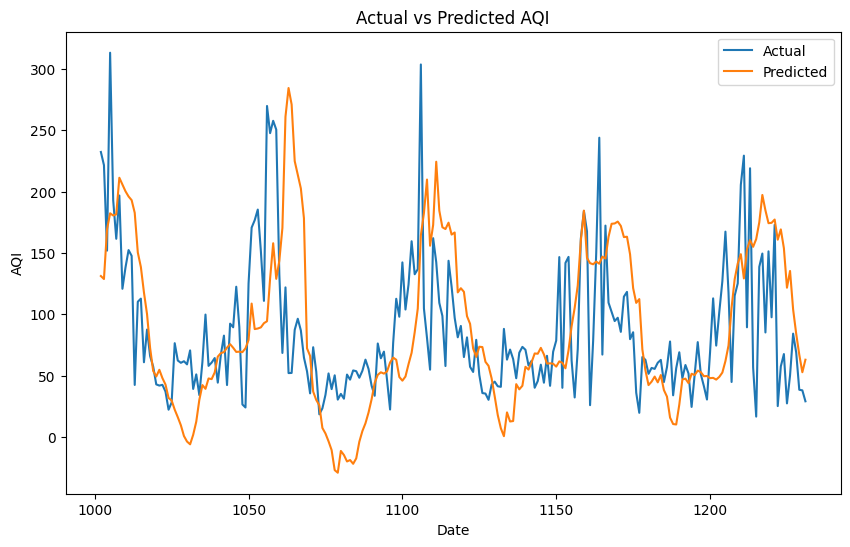

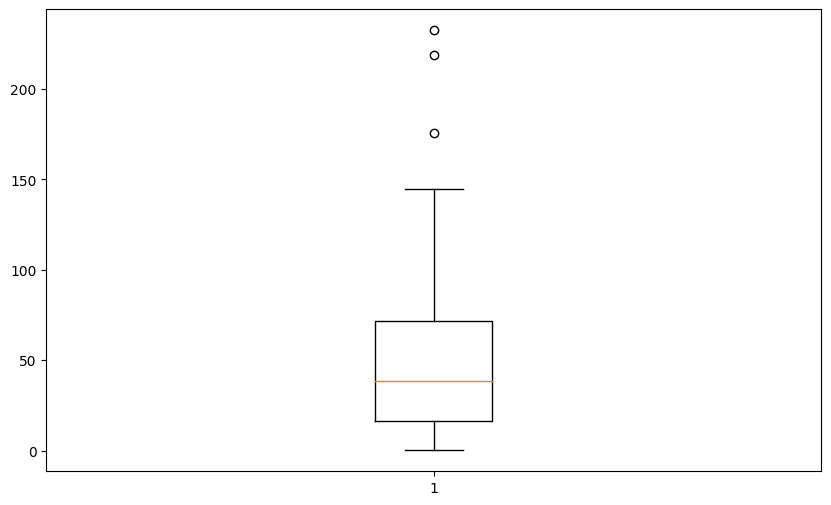


Results for dataset_aqi_hourly.csv with label AQI, train_size=6.0 months, test_size=28 days:

Errors for 1 days:
MAE: 31.81401806330251
RMSE: 43.698125289555016
R2: 0.44193408702357073
SMAPE: 41.466025761969796


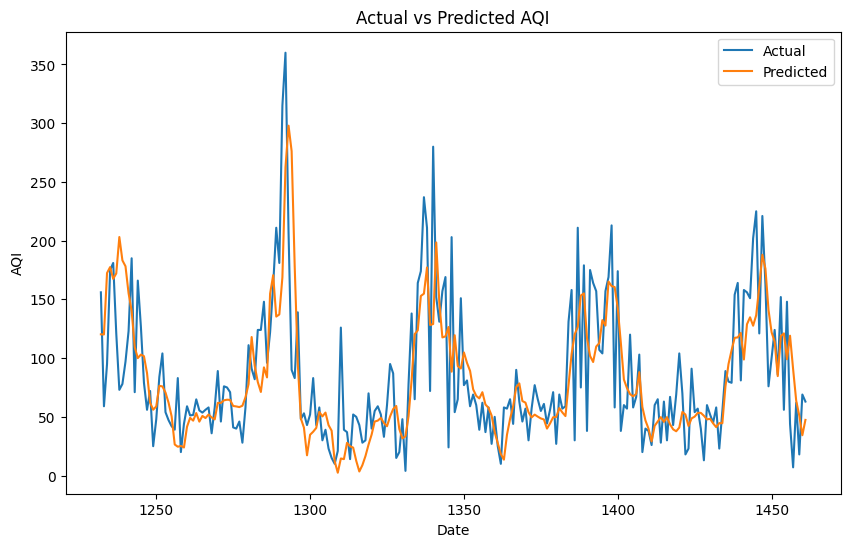

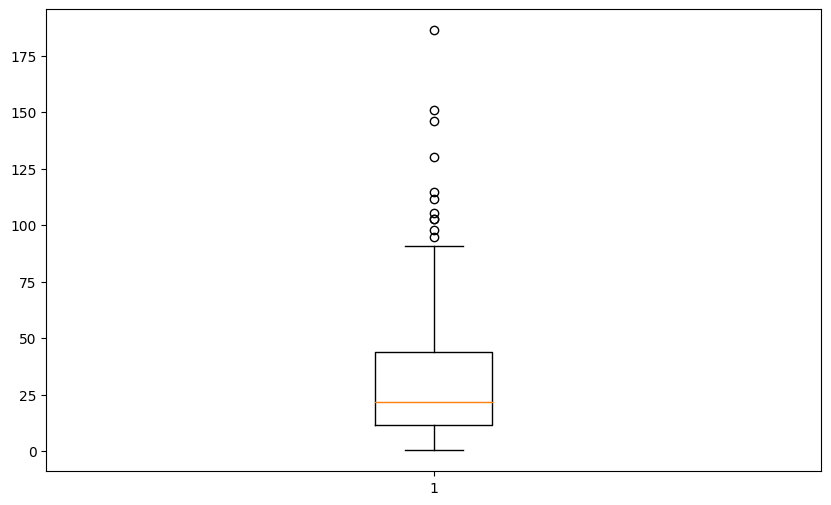

Errors for 7 days:
MAE: 33.47761461981557
RMSE: 48.32913013616327
R2: 0.46592068627495364
SMAPE: 33.1935150874474


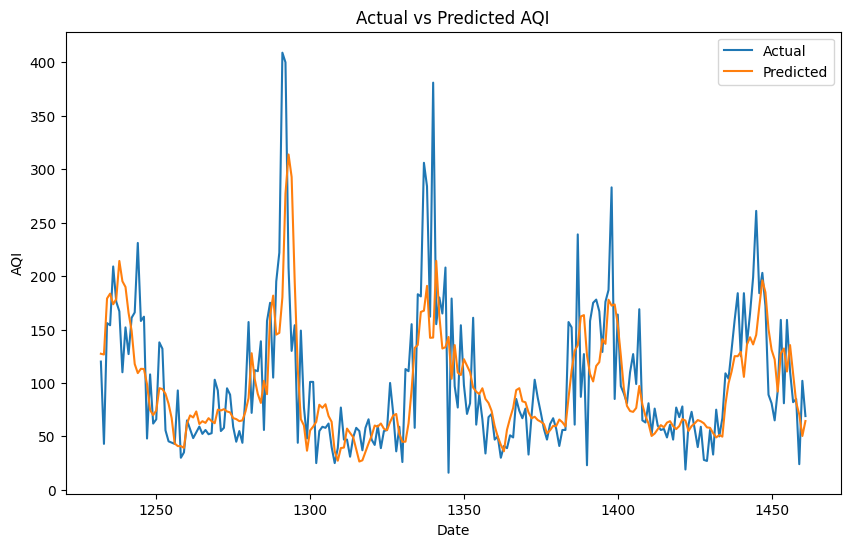

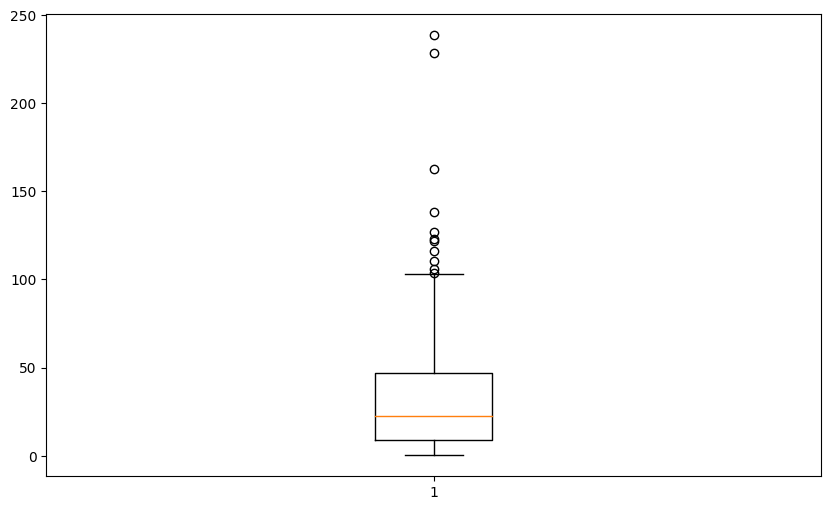

Errors for 14 days:
MAE: 34.090310744991704
RMSE: 47.38955873303507
R2: 0.2472522995155031
SMAPE: 45.31214223366198


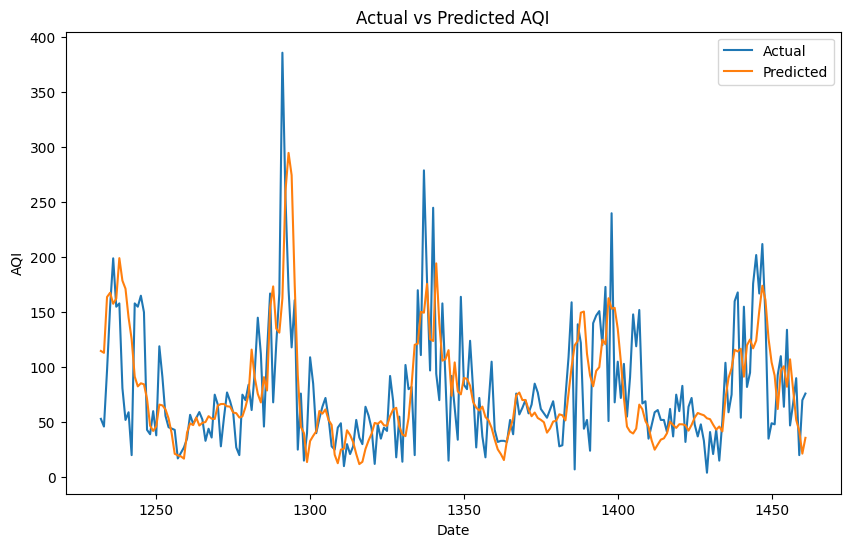

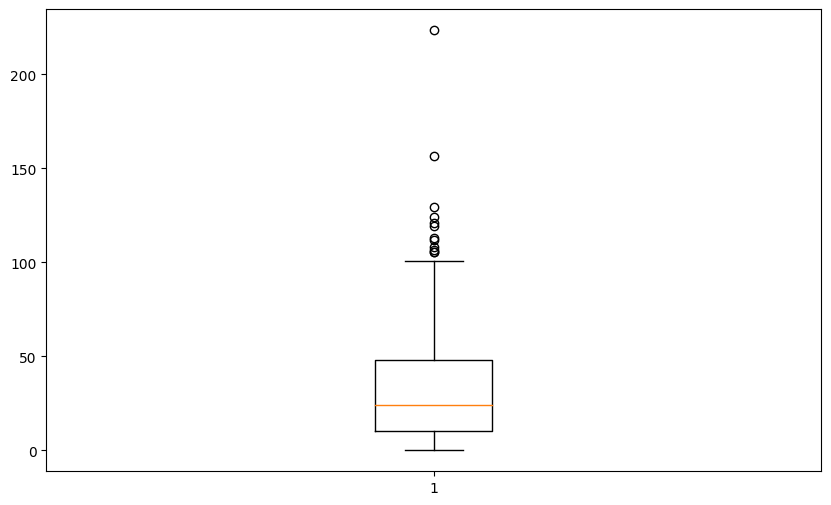

Errors for 28 days:
MAE: 40.065718722369226
RMSE: 61.03638586629173
R2: 0.3741457907883653
SMAPE: 40.09427762900479


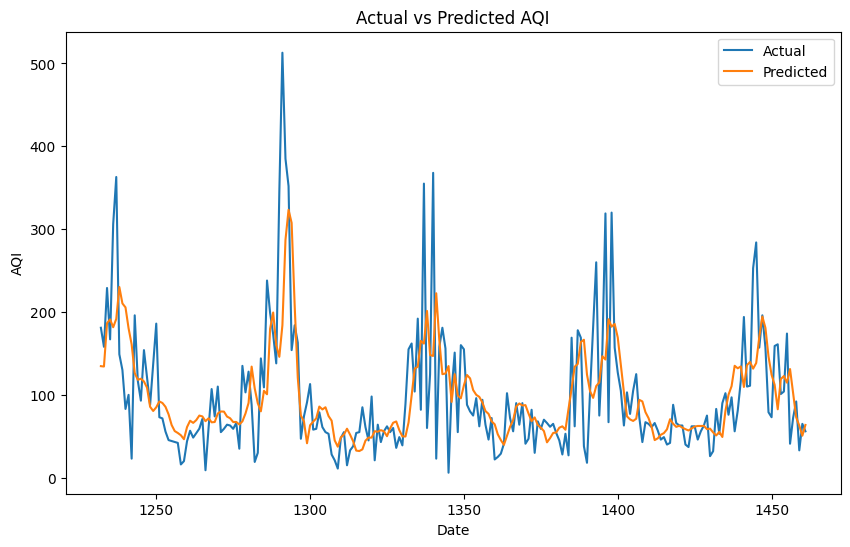

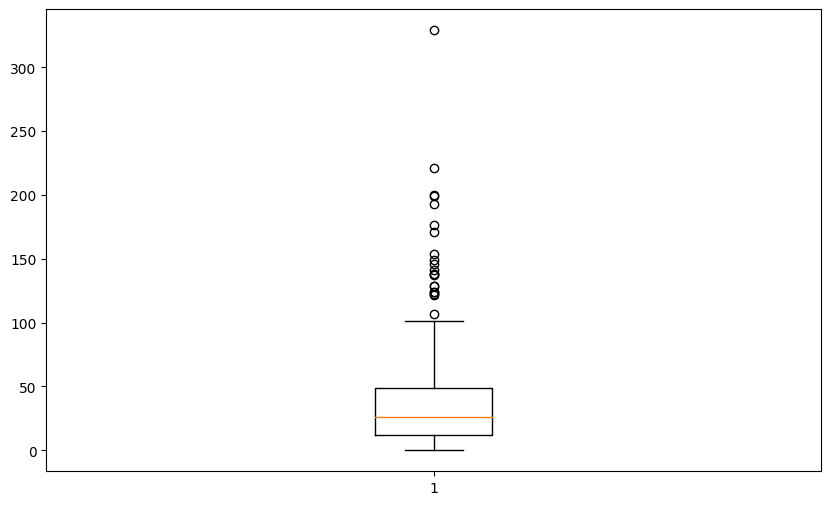


Results for dataset_aqi_daily_filled_with_neighbors.csv with label AQI, train_size=6.0 months, test_size=28 days:

Errors for 1 days:
MAE: 33.02678694946628
RMSE: 48.35119437051622
R2: 0.2921919321927242
SMAPE: 37.351586042011995


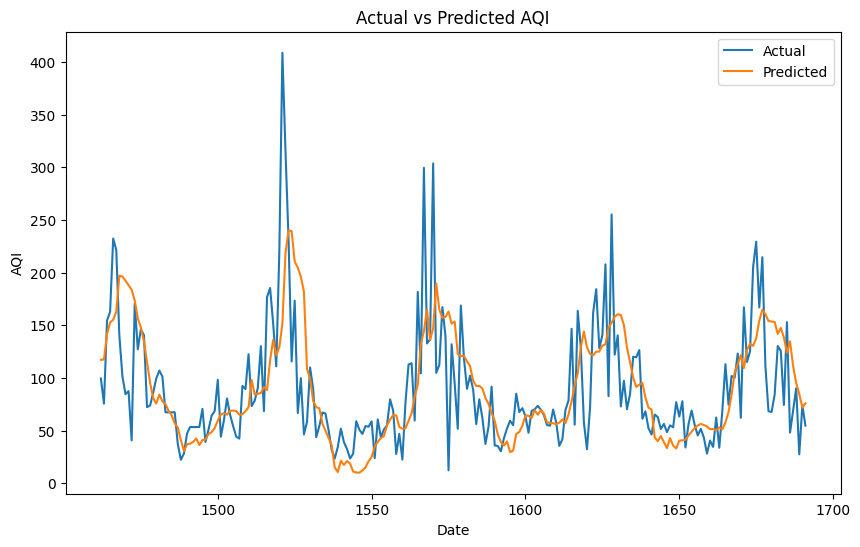

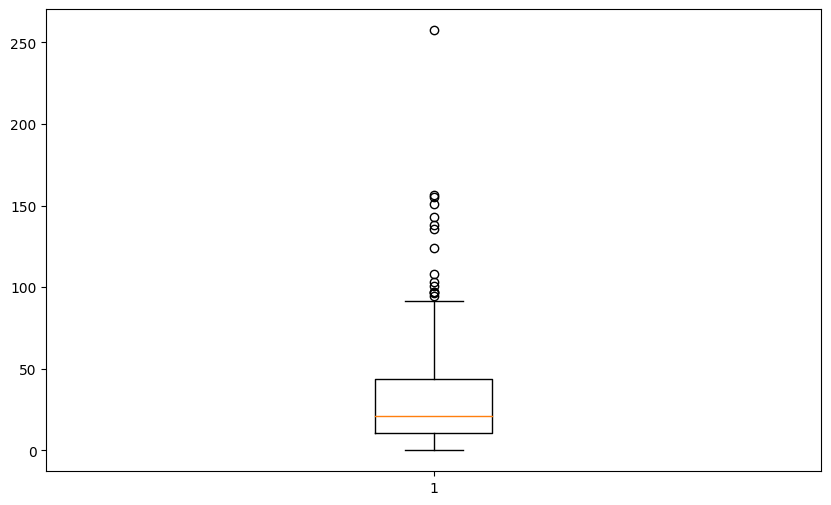

Errors for 7 days:
MAE: 35.35888134923672
RMSE: 49.0855447443365
R2: 0.14838142496885232
SMAPE: 44.803217657833244


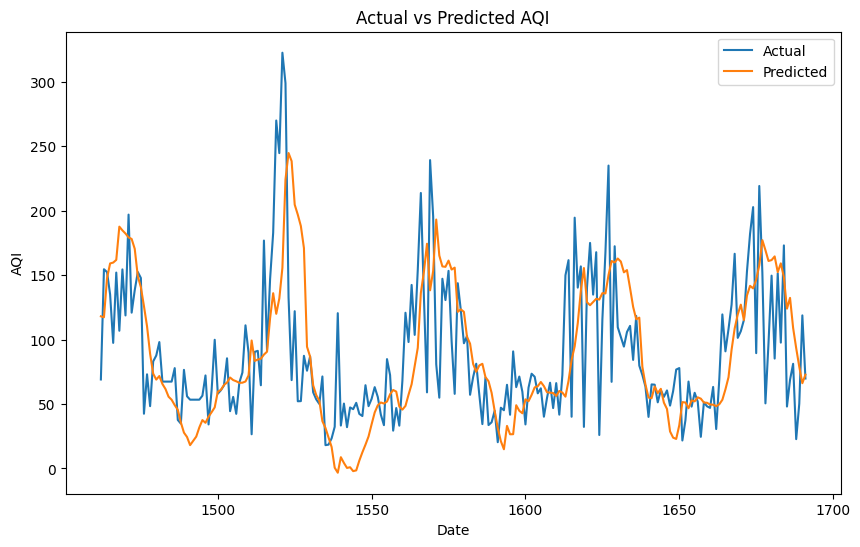

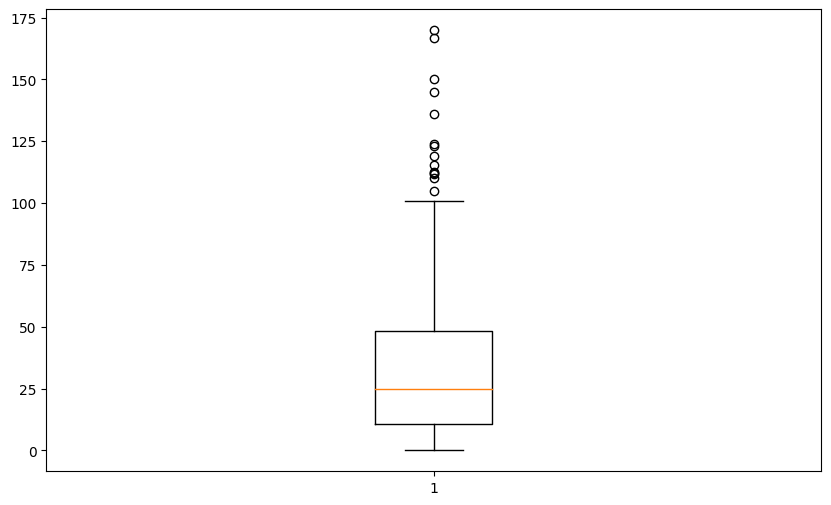

Errors for 14 days:
MAE: 40.82890781401377
RMSE: 55.410448936693086
R2: 0.004819553451229752
SMAPE: 51.59510913415738


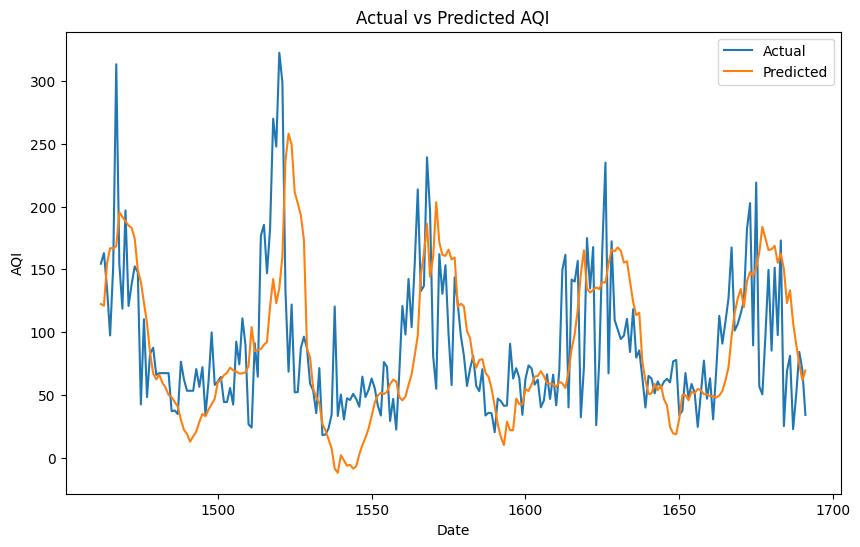

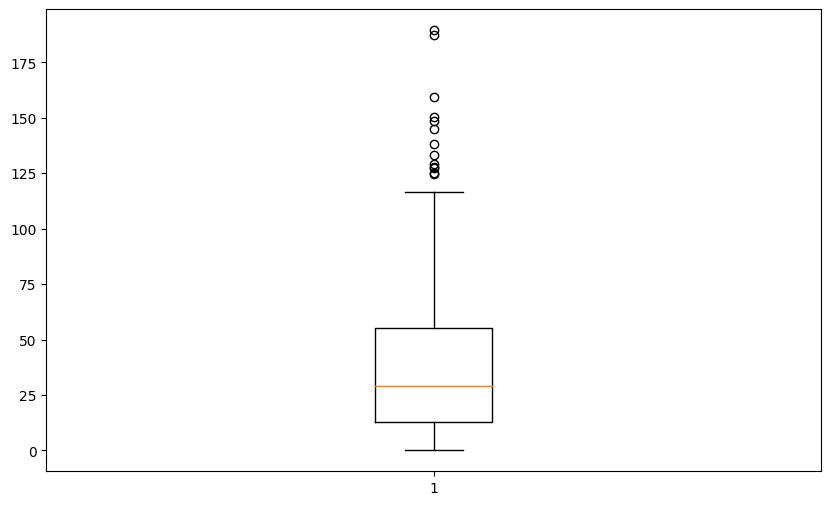

Errors for 28 days:
MAE: 48.30087016343494
RMSE: 62.53235724062649
R2: -0.2486012217242657
SMAPE: 62.825914185199636


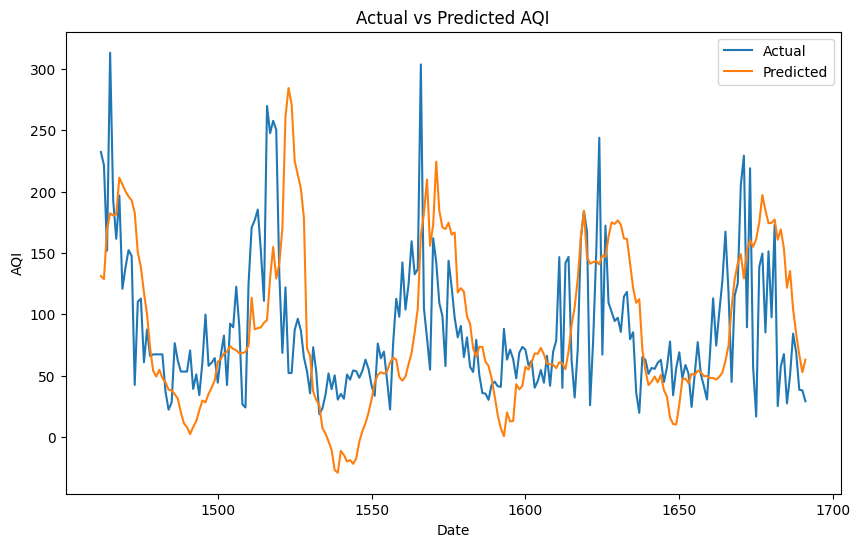

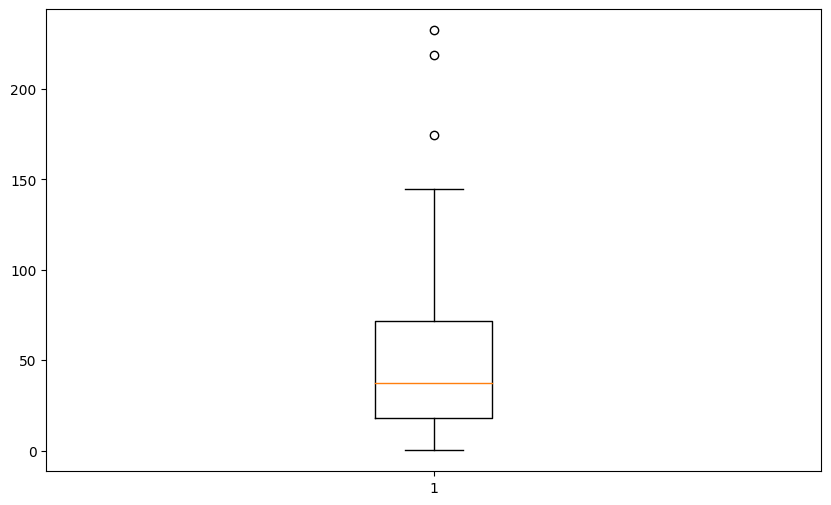


Results for dataset_aqi_hourly_filled_with_neighbors.csv with label AQI, train_size=6.0 months, test_size=28 days:

Errors for 1 days:
MAE: 31.769633781031686
RMSE: 43.71524163871346
R2: 0.44074938544257725
SMAPE: 41.27182879067842


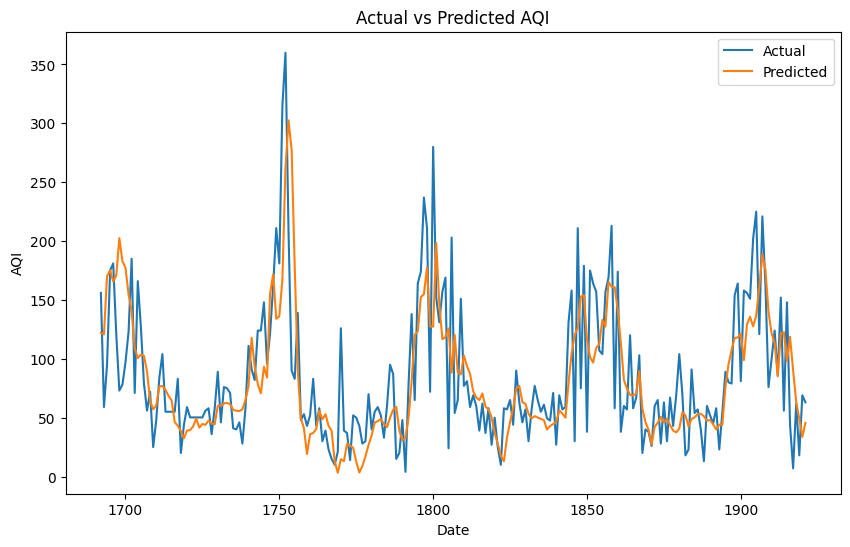

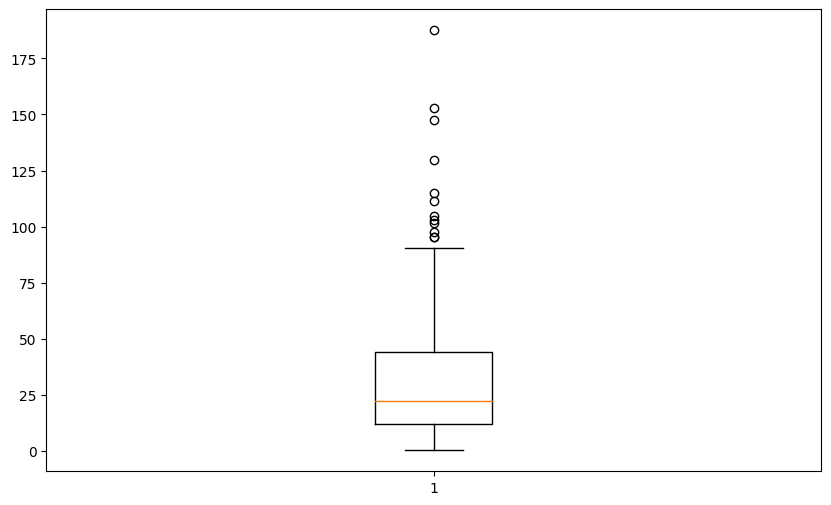

Errors for 7 days:
MAE: 33.02441042899592
RMSE: 48.16726706133145
R2: 0.46318395997118944
SMAPE: 32.47206096660859


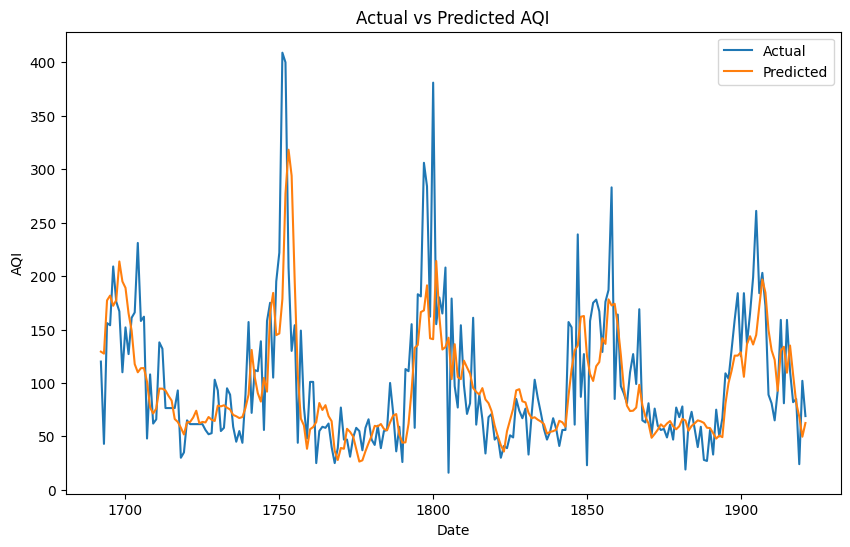

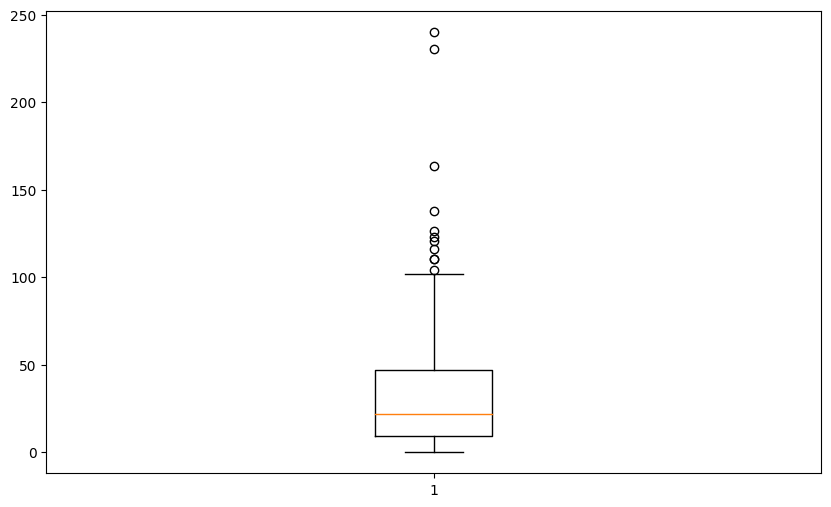

Errors for 14 days:
MAE: 34.07453734252679
RMSE: 47.45976997471409
R2: 0.2456353614072483
SMAPE: 45.29686703690516


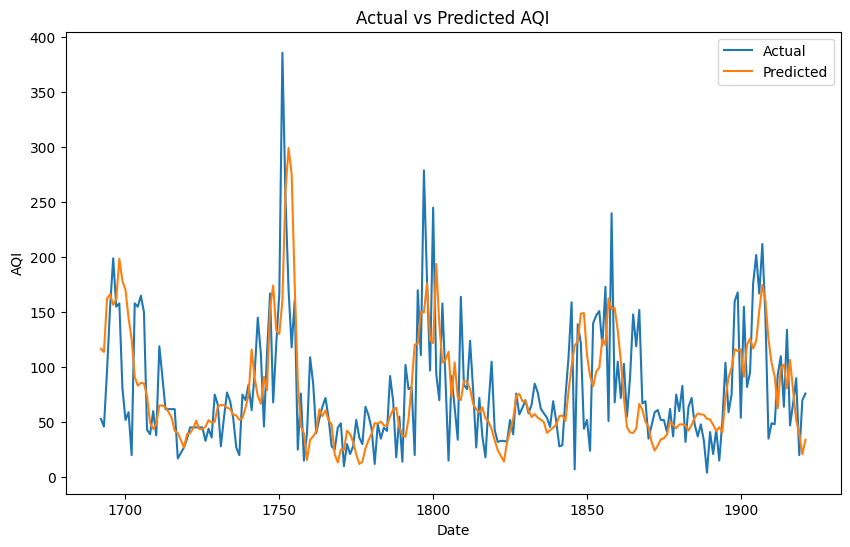

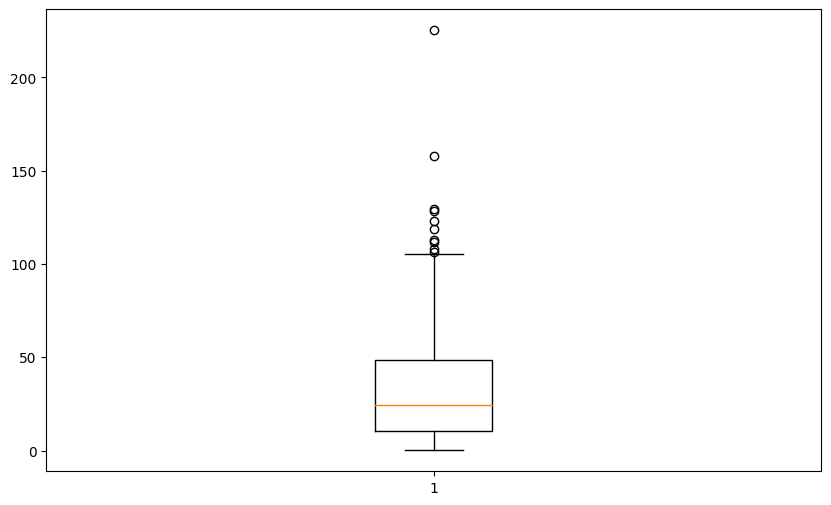

Errors for 28 days:
MAE: 40.03427459156112
RMSE: 61.20496635629507
R2: 0.3676617080223047
SMAPE: 39.933584679976455


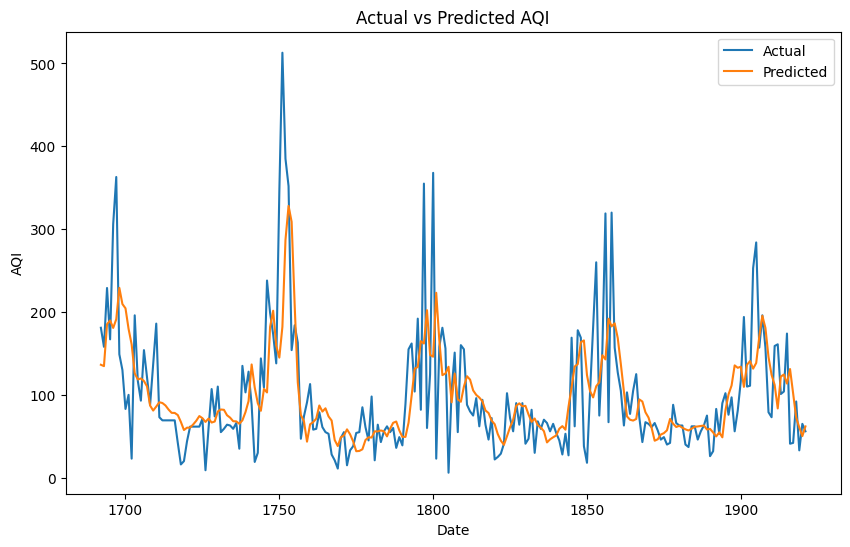

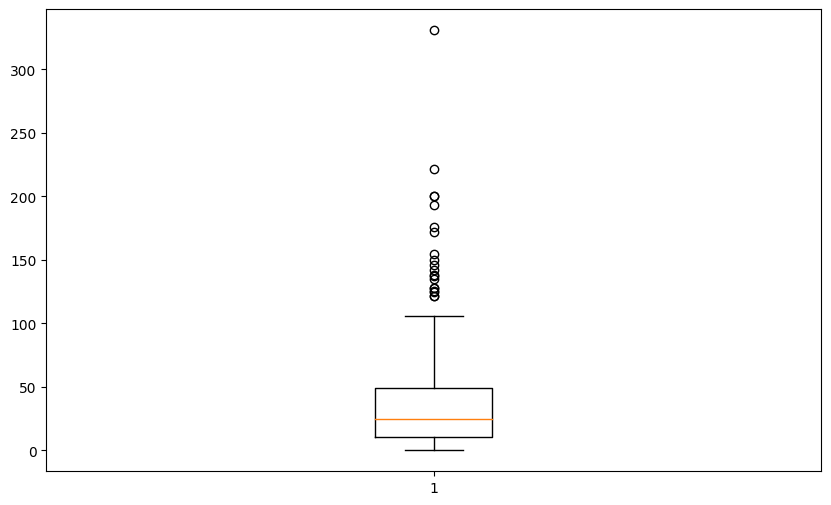

In [32]:
df_results = pd.read_csv(results_file_path)

# convert to datetime
df_results['DateTime of experiment'] = pd.to_datetime(df_results['DateTime of experiment'])
df_results['Training data from'] = pd.to_datetime(df_results['Training data from'])
df_results['Training data to'] = pd.to_datetime(df_results['Training data to'])
df_results['Testing data from'] = pd.to_datetime(df_results['Testing data from'])
df_results['Testing data to'] = pd.to_datetime(df_results['Testing data to'])
# convert Test Data and Test Predictions to lists of doubles
df_results['Test Data'] = df_results['Test Data'].apply(lambda x: json.loads(x))
df_results['Test Predictions'] = df_results['Test Predictions'].apply(lambda x: json.loads(x))
# calculate time delta in months round to 0 decimals
df_results['Training Duration'] = ((df_results['Training data to'] - df_results['Training data from']) / np.timedelta64(1, 'M')).round(0).astype(int)
df_results['Testing duration'] = ((df_results['Testing data to'] - df_results['Testing data from']) / np.timedelta64(1, 'D')).round(0).astype(int)

for experiment_case in experiment_cases:
    filename = experiment_case['filename']
    label = experiment_case['label']
    train_size = experiment_case['train_size']
    test_sizes = experiment_case['test_sizes']

    print(f'\nResults for {filename} with label {label}, train_size={train_size} months, test_size={test_sizes[0]} days:\n')

    df_results_filtered = df_results[(df_results['Dataset used'] == filename) & (df_results['Label predicted'] == label) & (df_results['Training Duration'] == train_size) & (df_results['Testing duration'] == test_sizes[0])]

    # Columns that contain list of predictions for each experiment
    tests_column = df_results_filtered['Test Data']
    predictions_column = df_results_filtered['Test Predictions']

    # Calculating errors for 1, 7, 14, 28 days and plotting forecast plot and boxplot
    for i in [1, 7, 14, 28]:
        # take i-1-th (-1 because enumerations starts from 0) element from each list of tests and predictions columns
        tests = tests_column.apply(lambda x: x[i-1])
        predictions = predictions_column.apply(lambda x: x[i-1])

        # Calculate errors
        mae = mean_absolute_error(tests, predictions)
        rmse = np.sqrt(mean_squared_error(tests, predictions))
        r2 = r2_score(tests, predictions)
        smape = calculate_smape(tests, predictions)

        print(f'Errors for {i} days:')
        print(f'MAE: {mae}')
        print(f'RMSE: {rmse}')
        print(f'R2: {r2}')
        print(f'SMAPE: {smape}')

        # Plot forecast plot and boxplot
        plt.figure(figsize=(10,6))
        plt.plot(tests, label='Actual')
        plt.plot(tests.index, predictions, label='Predicted')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel(label)
        plt.title('Actual vs Predicted ' + label)
        plt.show()

        plot_boxplot(predictions, tests)